In [57]:
library(dplyr)
library(magrittr)
library(readr)
library(tidyr)
library(purrr)
library(stringr)
library(here)
library(sf)
library(ncdf4)
library(rgdal) # Dependencies: https://stackoverflow.com/questions/15248815/rgdal-package-installation
library(raster)
library(scales)
library(psych)
library(caret)
library(lubridate)
library(padr)
library(tsibble)
library(feasts)
library(fabletools)
library(kableExtra)
library(ggpubr)
# These themes just look great :-)
# Download from devtools::install_github('cttobin/ggthemr')
library(ggthemr)
library(viridis)
library(leaflet)
# library(geojsonio) # Not 100% sure if this is needed


ggthemr("fresh")

devtools::load_all(".")

library(conflicted)
conflict_prefer(name = "select", winner = "dplyr")
conflict_prefer(name = "filter", winner = "dplyr")
conflict_prefer(name = "lag", winner = "dplyr")
conflict_prefer(name = "rescale", winner = "scales")
conflict_prefer(name = "here", winner = "here")

# To populate them in renv.lock
library(httpgd)
library(languageserver)

Loading CHAPo

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::select over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::filter over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::lag over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer scales::rescale over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer here::here over any other package



In [58]:
# Cosmo-1e with Assimilation of Real-Time Pollen Data
assim_path <- "/scratch/sadamov/wd/20_alnu_osm/mod_pollen_combined.txt"

# Cosmo-1e Baselines
cosmo_path <- "/scratch/sadamov/wd/20_alnu_assim_v1/mod_pollen_combined.txt"

# Measured Aggregates from the DWH for the 2020 season
dwh_path <- (paste0(here::here(), "/data/dwh/pollen_dwh_hourly.txt"))


In [60]:
# The following types are being modelled:
# Erle - Alder - Aulne - Alnus
# Birke - Birch - Bouleau - Betula
# Gräser - Grasses - Graminées - Poaceae
# Ambrosia - Ragweed - Ambroisie - Ambrosia

species_all <- tibble(
  taxon = c(
    "Castanea",
    "Alnus",
    "Ulmus",
    "Cupressus",
    "Fraxinus",
    "Fagus",
    "Juglans",
    "Plantago",
    "Corylus",
    "Pinus",
    "Quercus",
    "Rumex",
    "Platanus",
    "Populus",
    "Poaceae",
    "Salix",
    "Betula",
    "Carpinus",
    "Urtica",
    "Taxus",
    "Picea",
    "Ambrosia"
  ),
  hirst_taxon = c(
    "kacasth0",
    "kaalnuh0",
    "kaulmuh0",
    "kacuprh0",
    "kafraxh0",
    "kafaguh0",
    "kajuglh0",
    "khplanh0",
    "kacoryh0",
    "kapinuh0",
    "kaquerh0",
    "khrumeh0",
    "kaplath0",
    "kapopuh0",
    "khpoach0",
    "kasalih0",
    "kabetuh0",
    "kacarph0",
    "khurtih0",
    "kataxuh0",
    "kapiceh0",
    "khambrh0"
  ),
  cosmo_taxon = c(
    NA_character_,
    "ALNU",
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    "POAC",
    NA_character_,
    "BETU",
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    "AMBR"
  ),
  fieldextra_taxon = c(
    NA_character_,
    "ALNU1",
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    "POAC1",
    NA_character_,
    "BETU1",
    NA_character_,
    NA_character_,
    NA_character_,
    NA_character_,
    "AMBR1"
  )
)

species <- species_all %>%
  filter(taxon %in% c("Alnus", "Ambrosia", "Betula", "Poaceae"))

stations <-
  tibble(
    hirst_station = c(
      "PDS",
      "PBU",
      "PMU",
      "PBS",
      "PZH",
      "PLZ",
      "PBE",
      # "PPY",
      "PNE",
      "PVI",
      "PLS",
      "PGE",
      "PCF",
      "PLO",
      # "BLR",
      "PLU"
    ),
    station = c(
      "Wolfgang",
      "Buchs",
      "Münsterlingen",
      "Basel",
      "Zürich",
      "Luzern",
      "Bern",
      # "Payerne",
      "Neuchâtel",
      "Visp",
      "Lausanne",
      "Genève",
      "La-Chaux-de-Fonds",
      "Locarno",
      # "Balerna",
      "Lugano"
    ),
    cosmo_station = c(
      "CHDAVO",
      "CHBUCH",
      "CHMUEN",
      "CHBASE",
      "CHZUER",
      "CHLUZE",
      "CHBERN",
      # NA_character_,
      "CHNEUC",
      "CHVISP",
      "CHLAUS",
      "CHGENE",
      "CHLACH",
      "CHLOCA",
      # NA_character_,
      "CHLUGA"
    )
  ) %>%
  arrange(hirst_station)




In [61]:
data_cosmo_hourly <- import_data_cosmo(cosmo_path, type = "Cosmo")
data_assim_hourly <- import_data_cosmo(assim_path, type = "Assim")
data_dwh_hourly <- import_data_dwh(dwh_path)


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [62]:
data_cosmo_daily <- aggregate_pollen(data_cosmo_hourly)
data_assim_daily <- aggregate_pollen(data_assim_hourly)
data_dwh_daily <- aggregate_pollen(data_dwh_hourly)

In [63]:
data_dwh_hourly_imp <- impute_hourly(data_dwh_hourly)
data_dwh_daily_imp <- impute_daily(data_dwh_daily)
data_cosmo_hourly_imp <- impute_hourly(data_cosmo_hourly)
data_cosmo_daily_imp <- impute_daily(data_cosmo_daily)
data_assim_hourly_imp <- impute_hourly(data_assim_hourly)
data_assim_daily_imp <- impute_daily(data_assim_daily)

data_comb_daily <- data_dwh_daily_imp %>%
  bind_rows(data_cosmo_daily_imp) %>%
  bind_rows(data_assim_daily_imp)

data_comb_hourly <- data_dwh_hourly_imp %>%
  bind_rows(data_cosmo_hourly_imp) %>%
  bind_rows(data_assim_hourly_imp)

taxa_selected <- unique(data_assim_hourly$taxon)


pad applied on the interval: hour

pad applied on the interval: day

pad applied on the interval: hour

pad applied on the interval: day

pad applied on the interval: hour

pad applied on the interval: day



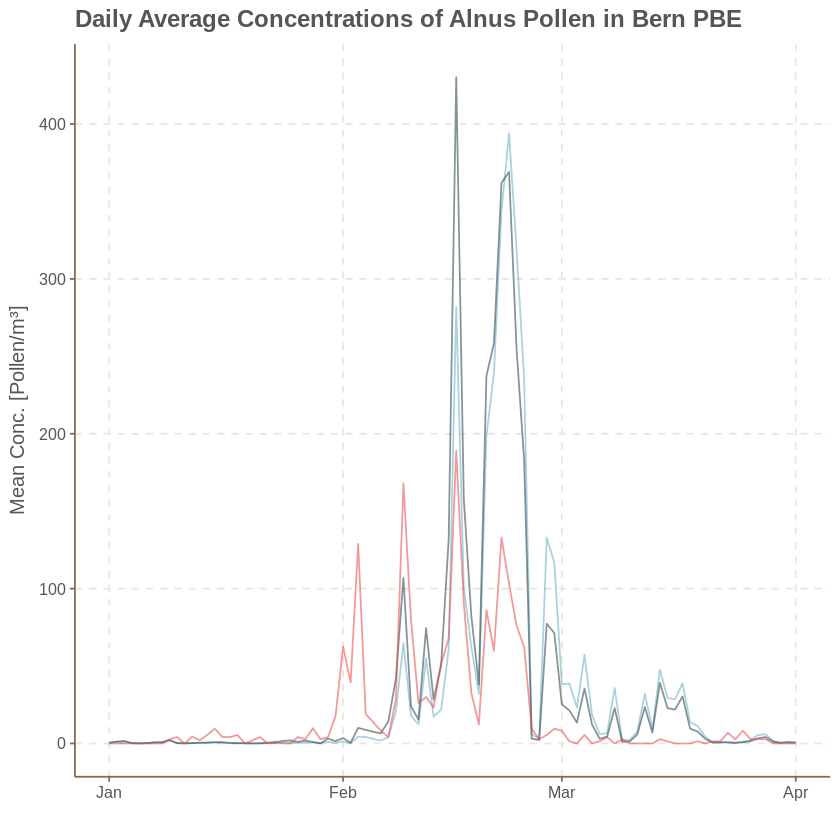

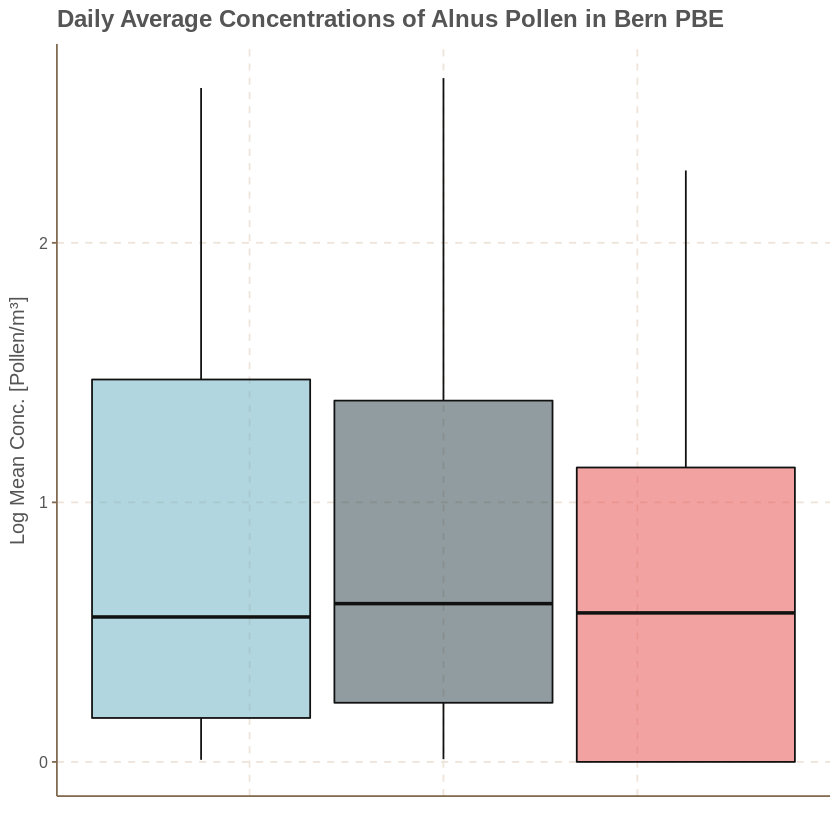

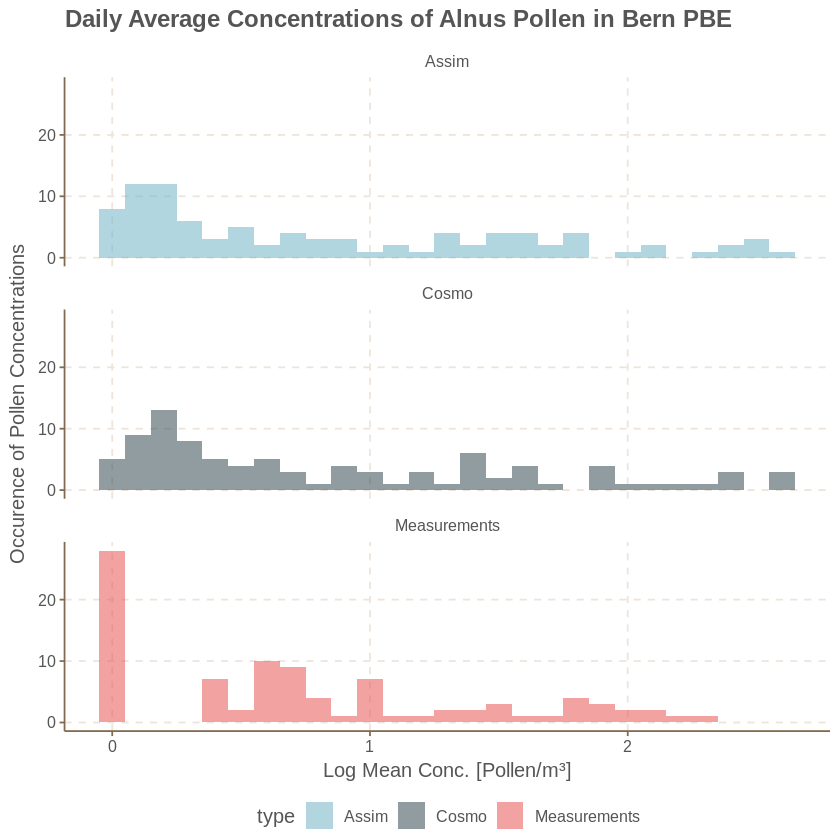

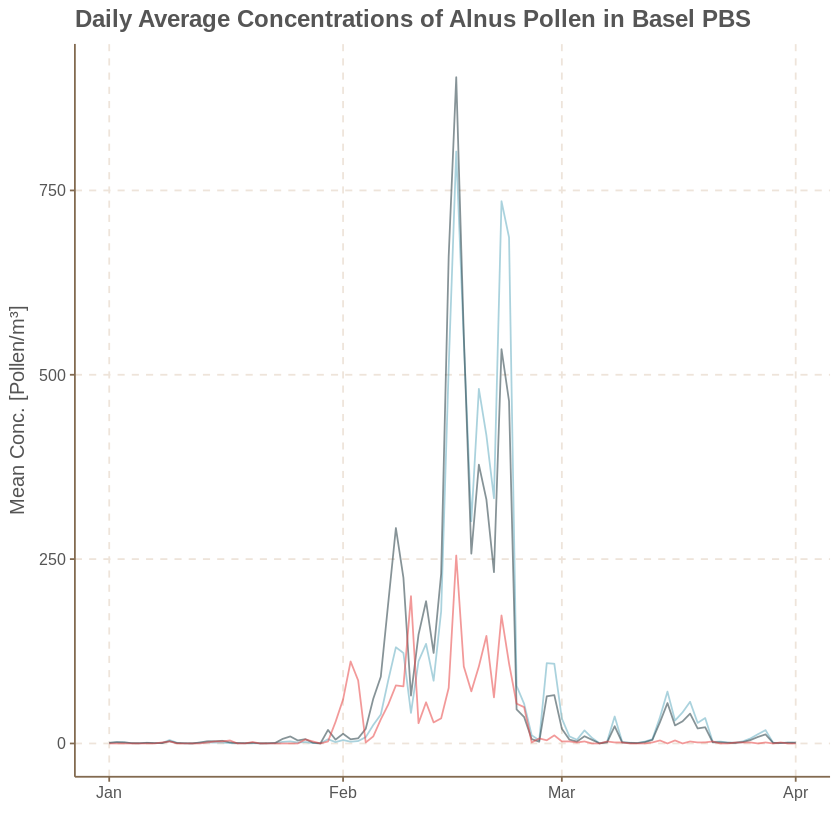

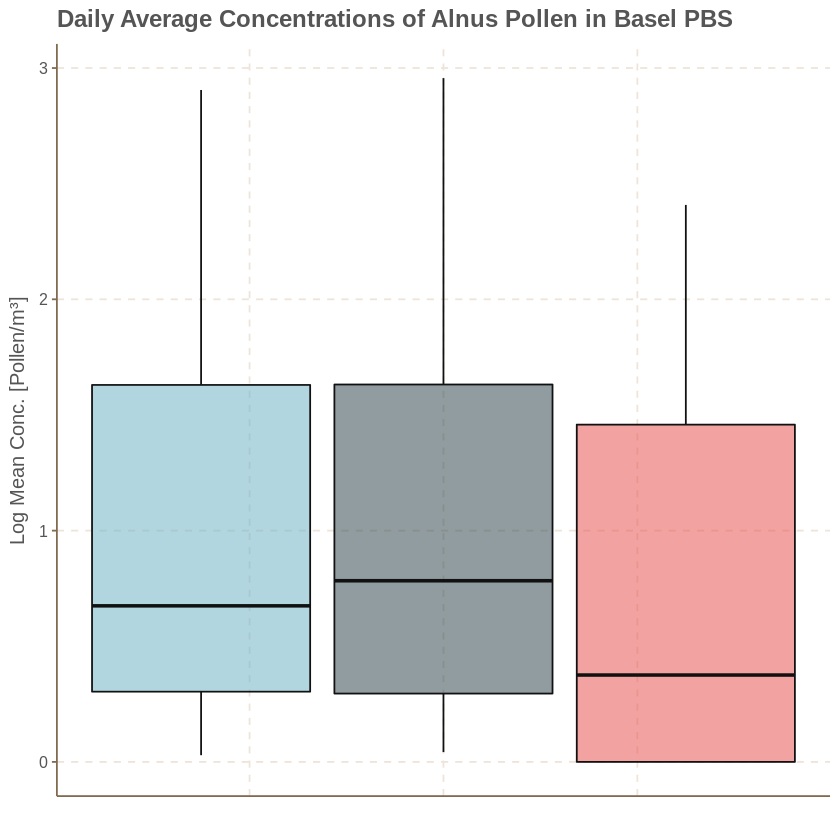

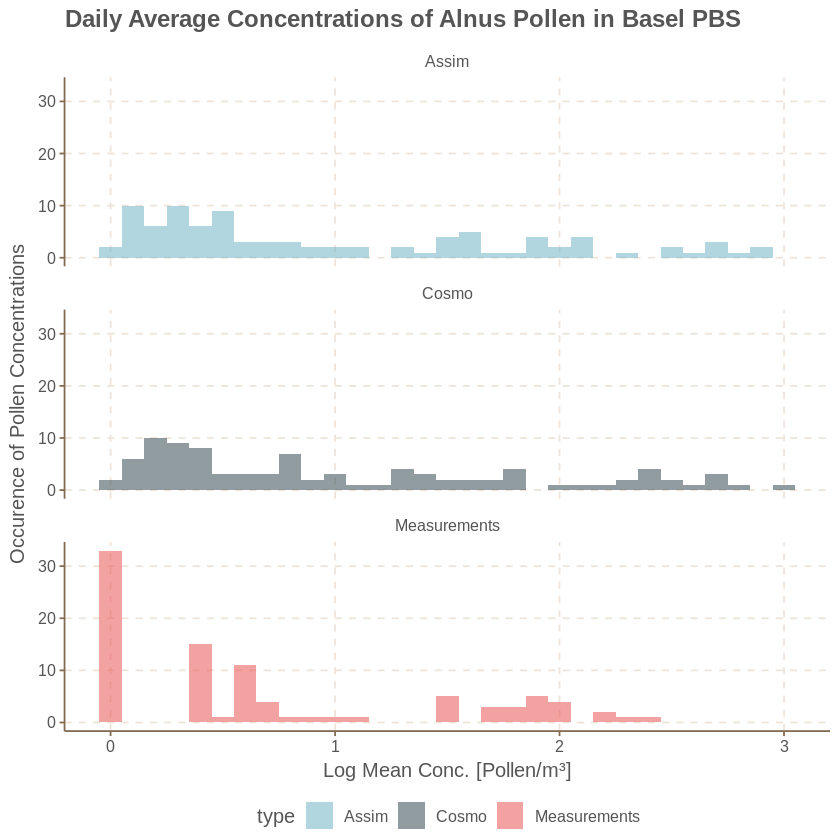

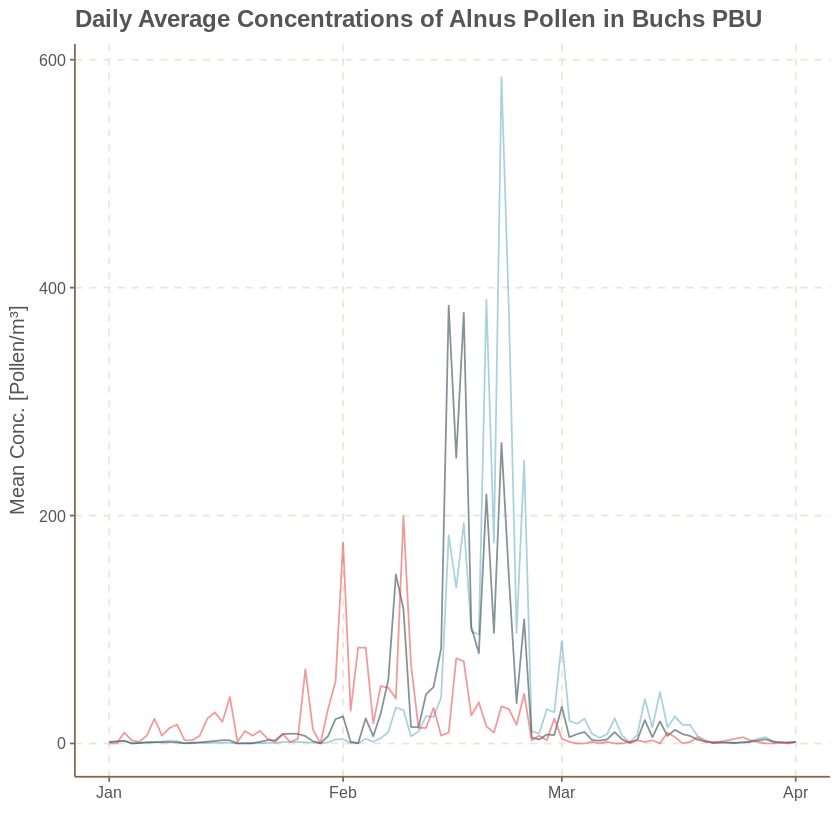

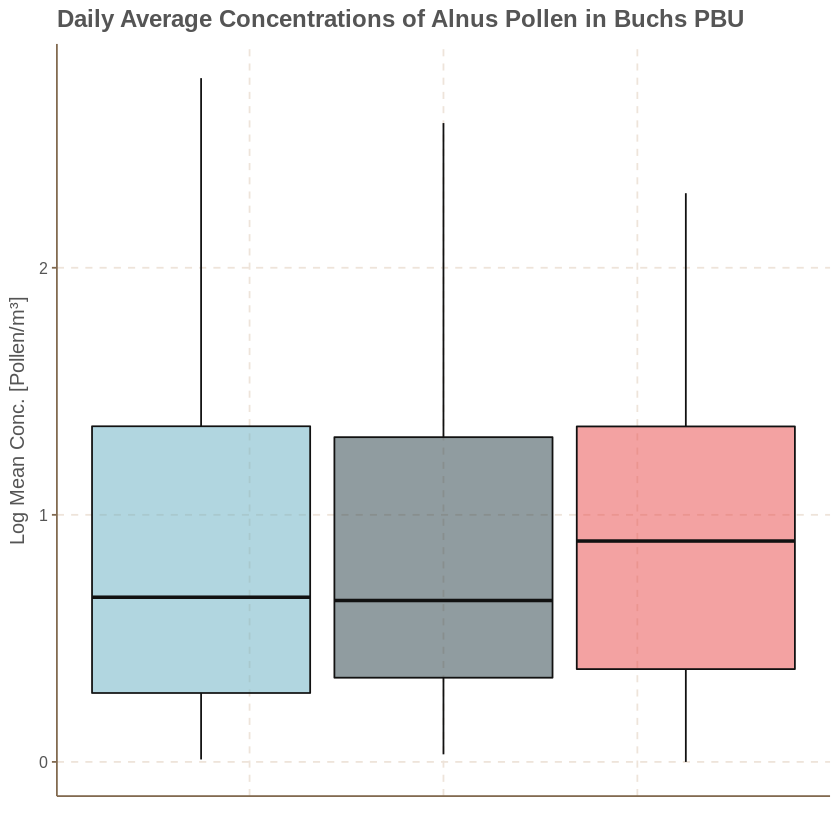

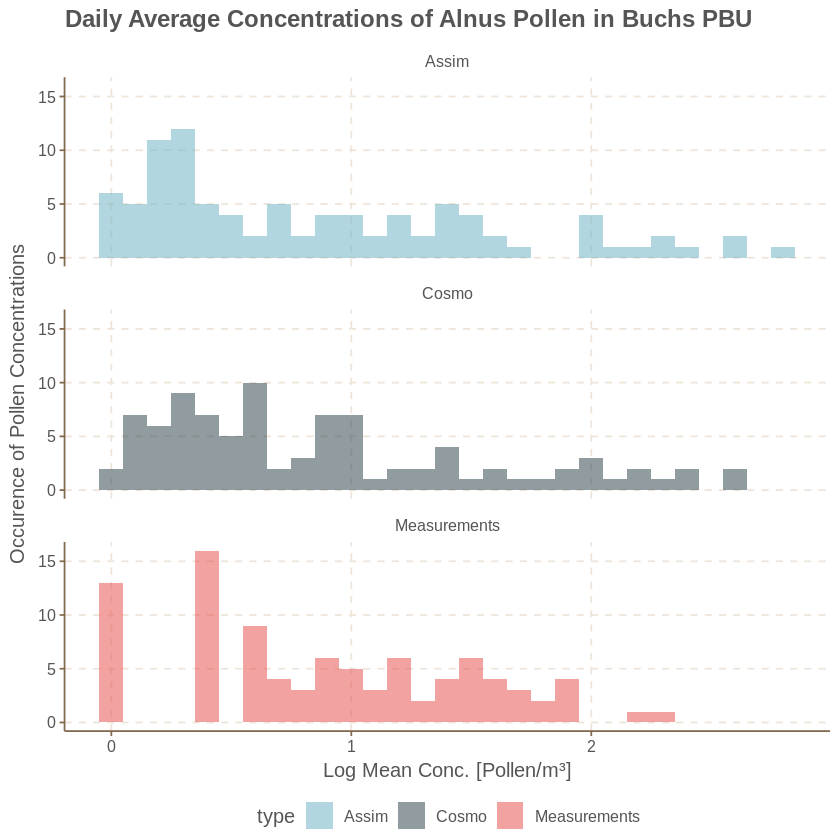

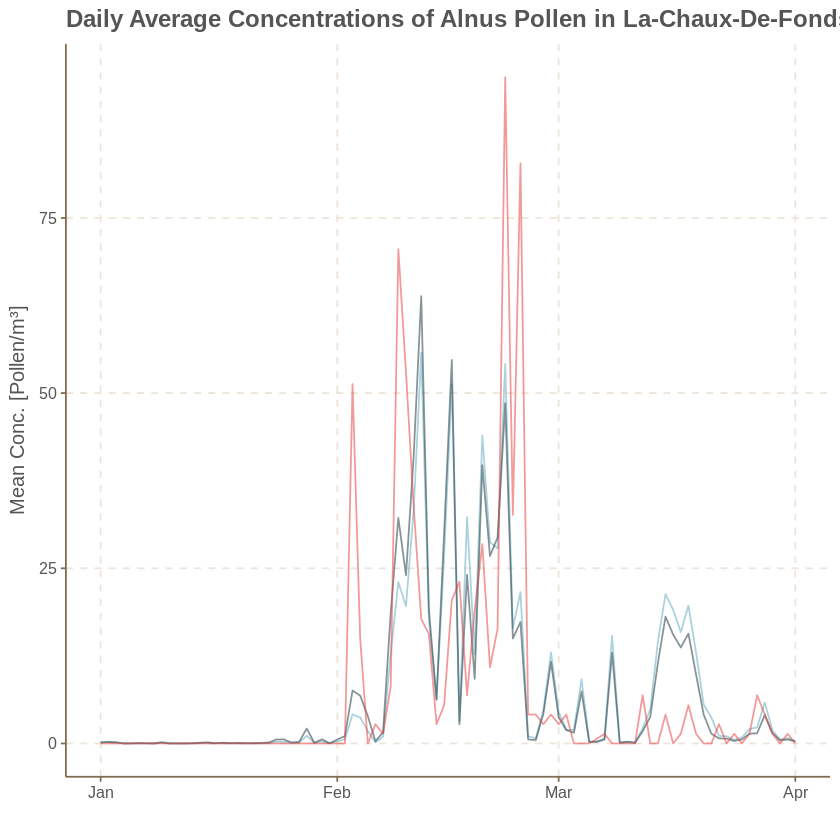

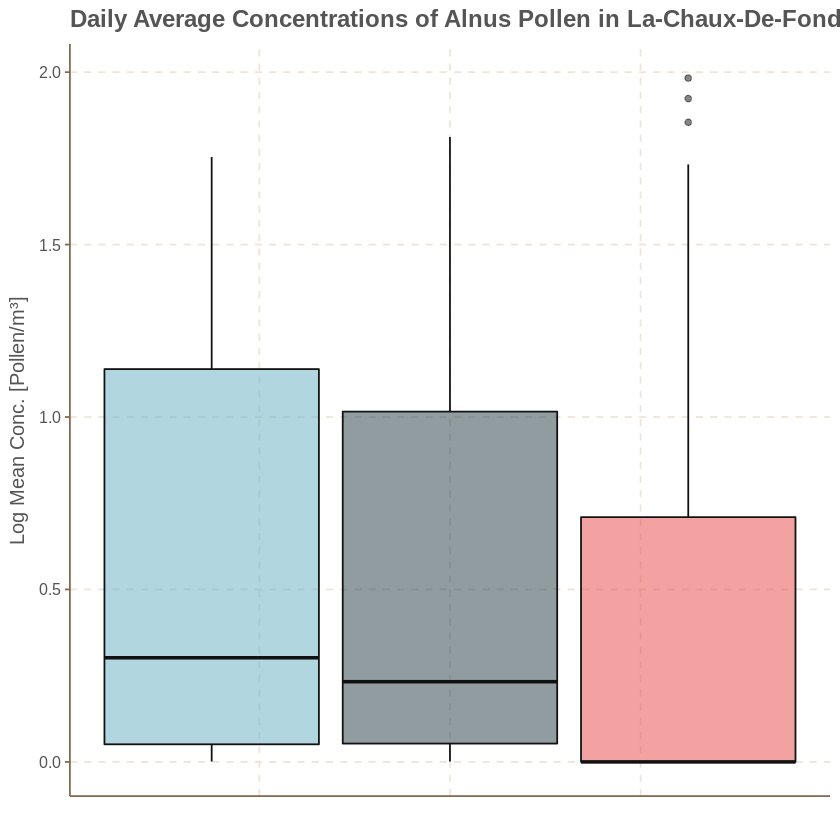

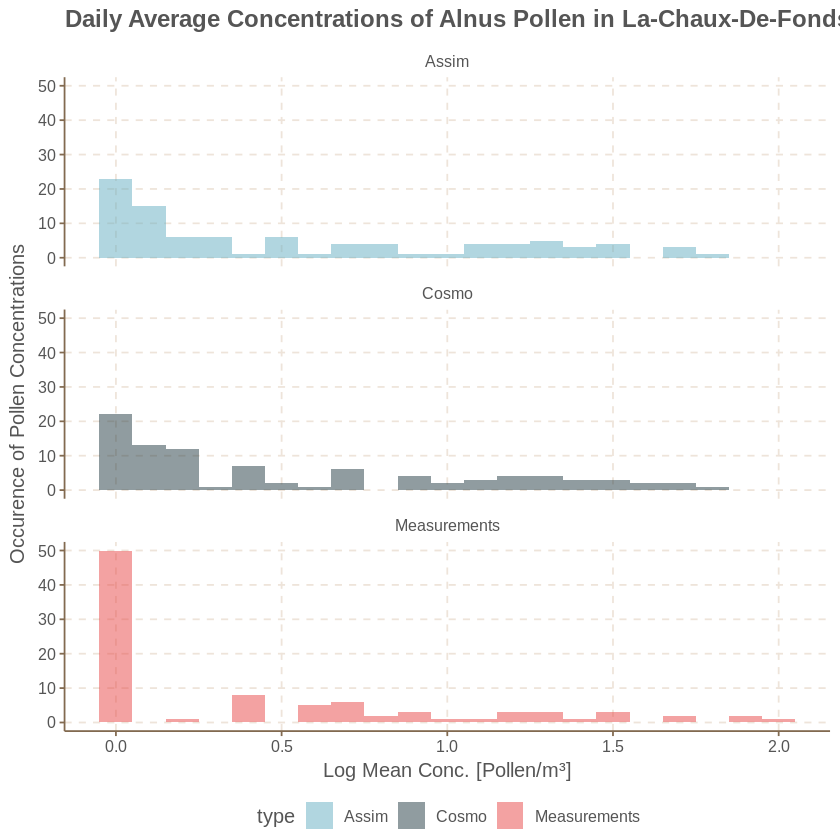

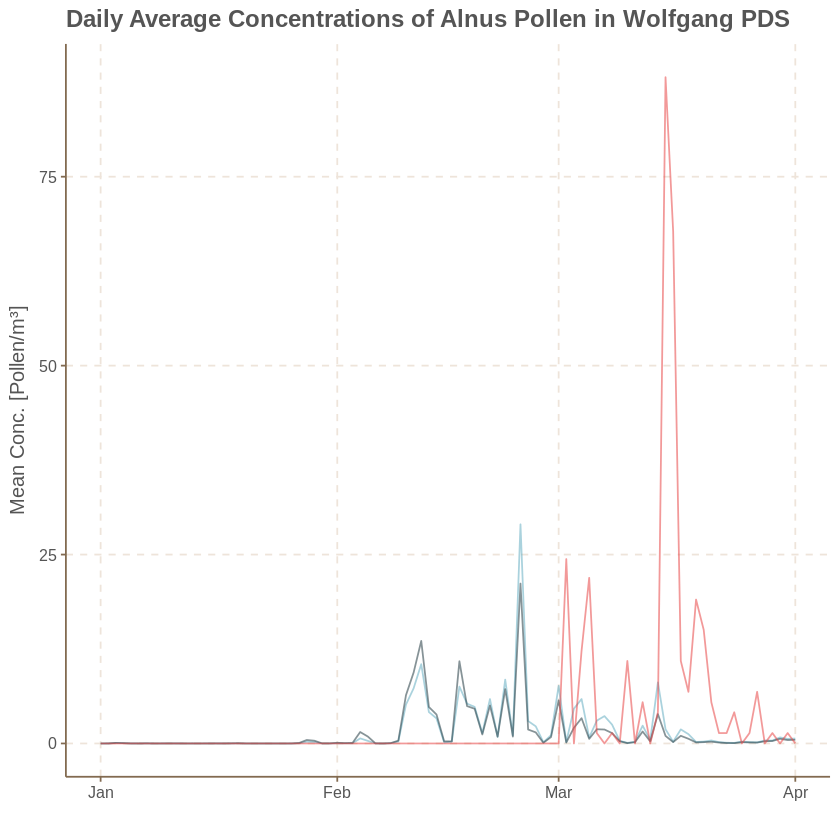

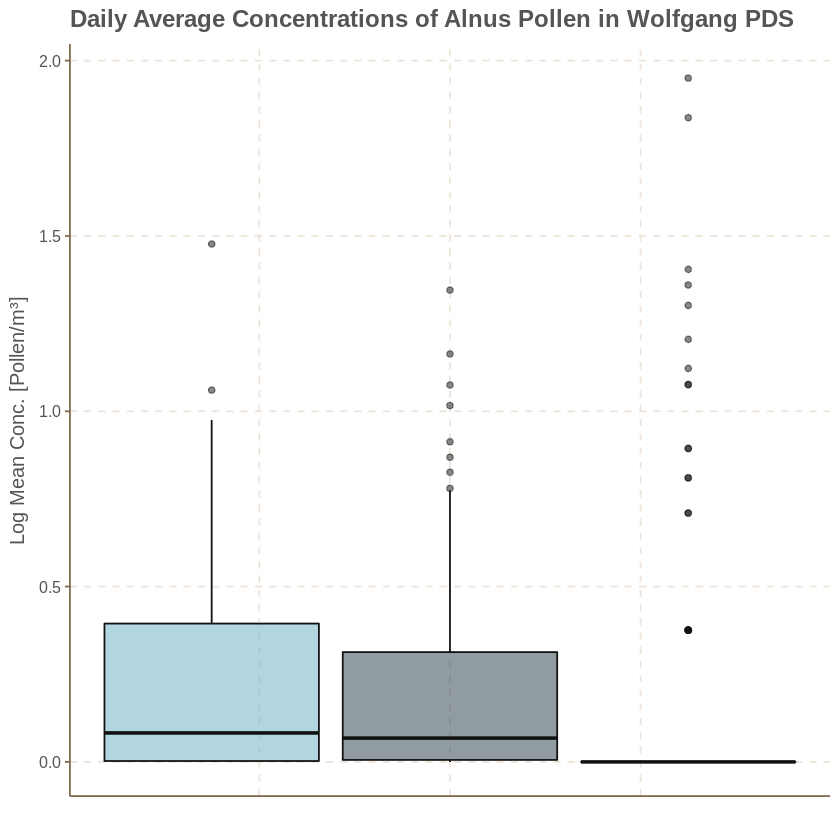

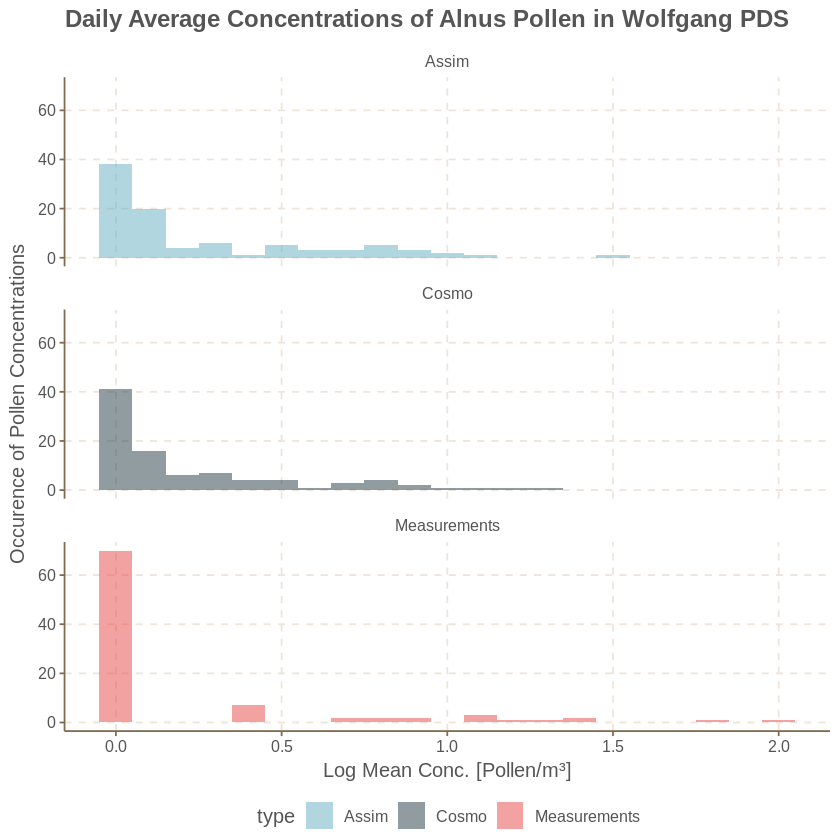

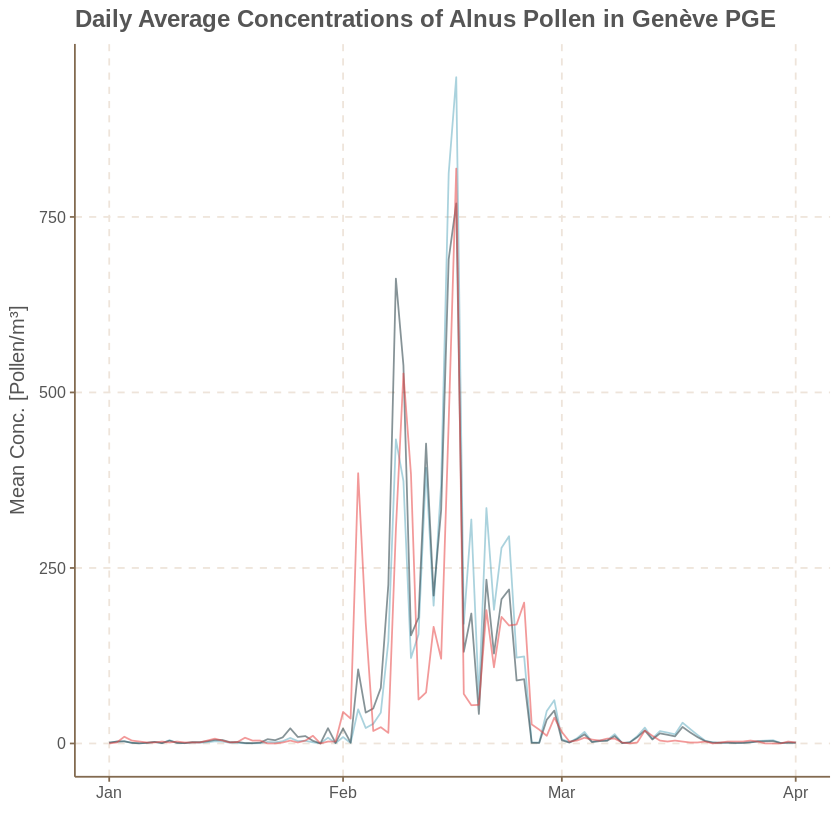

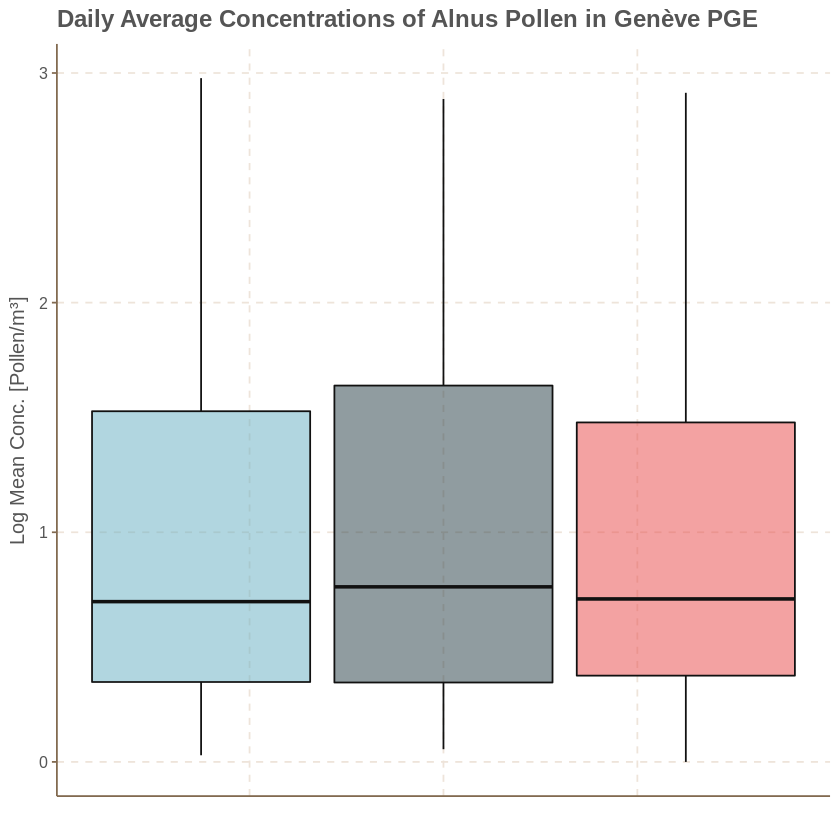

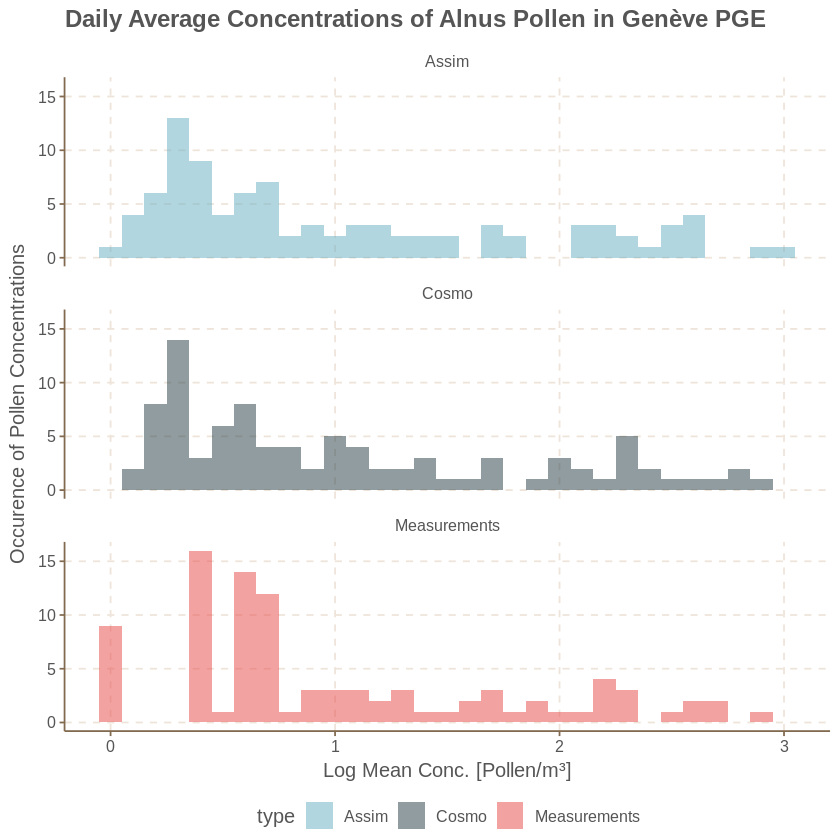

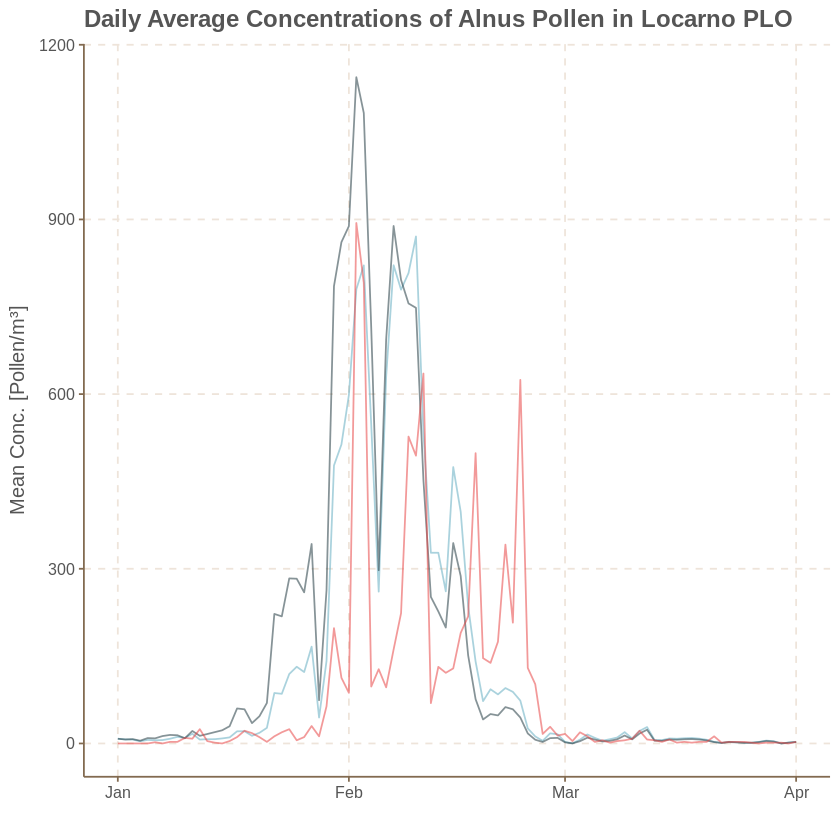

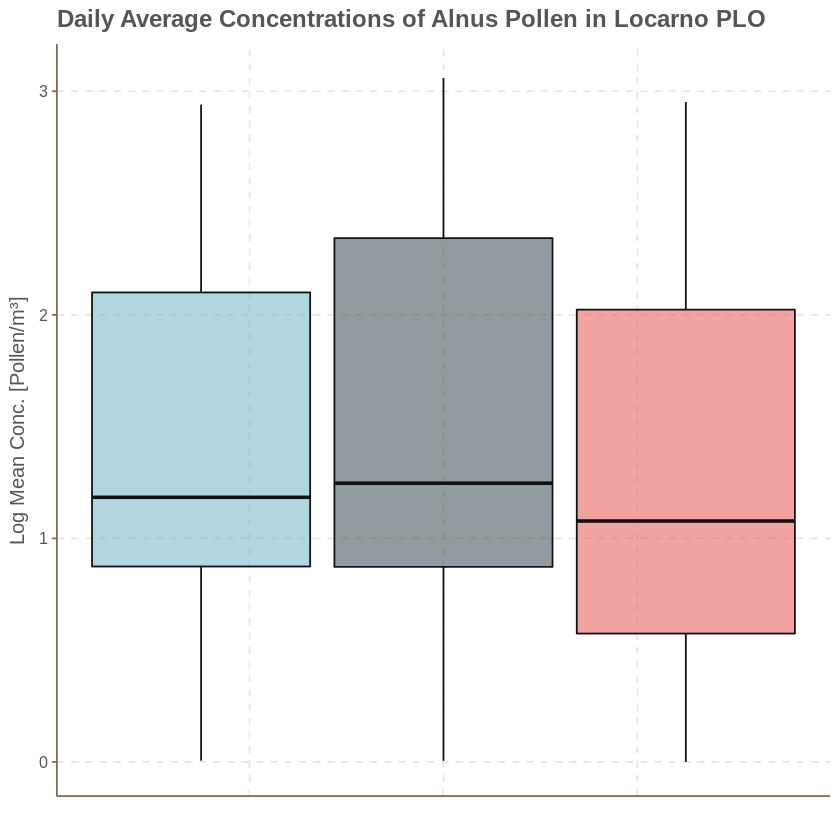

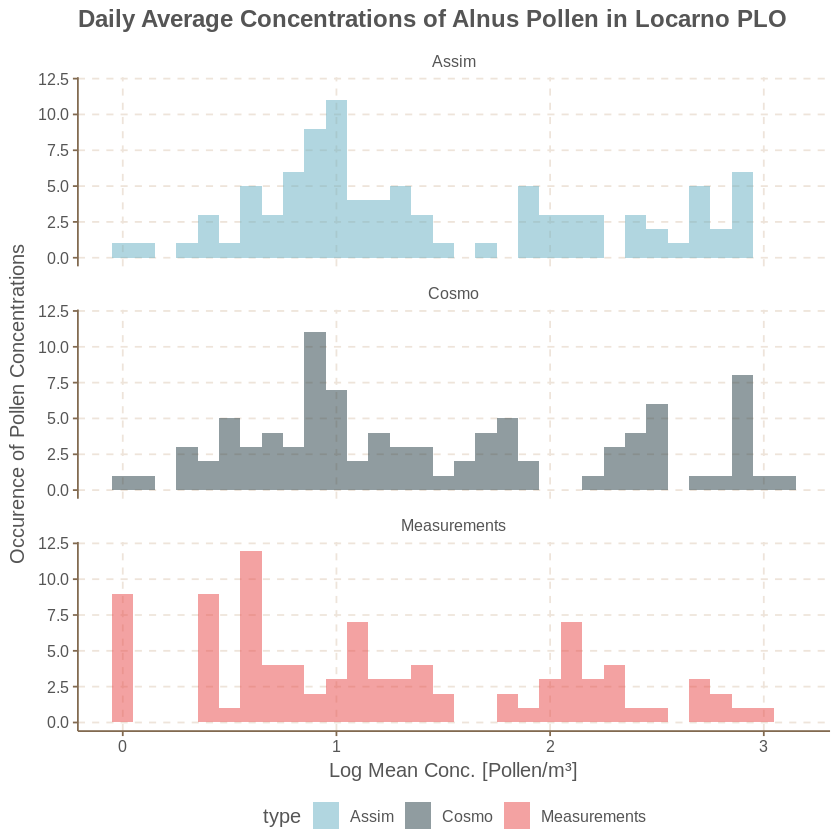

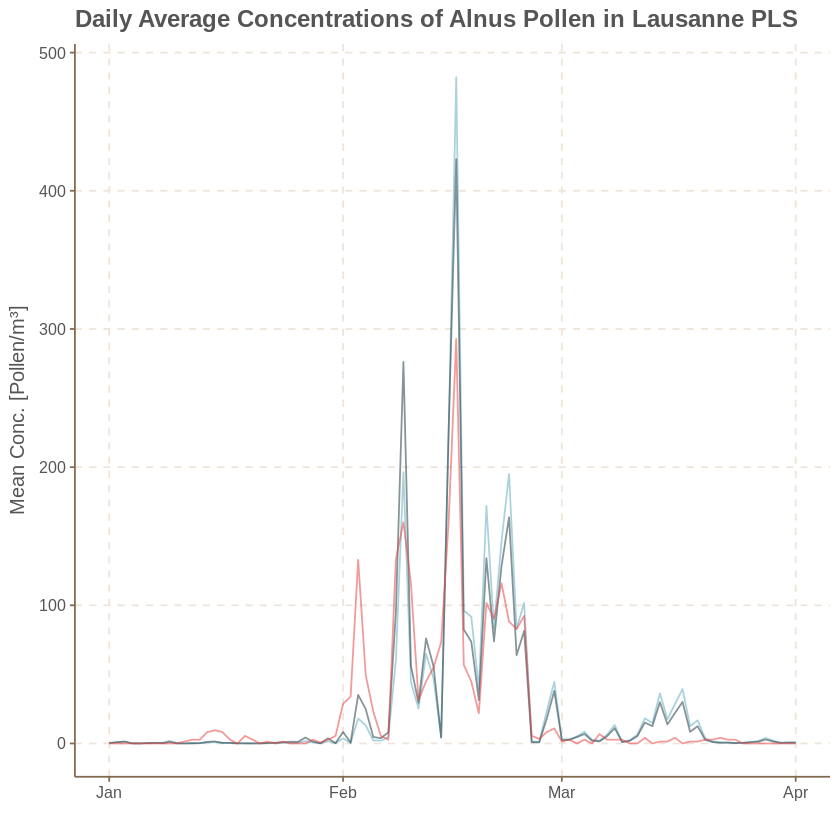

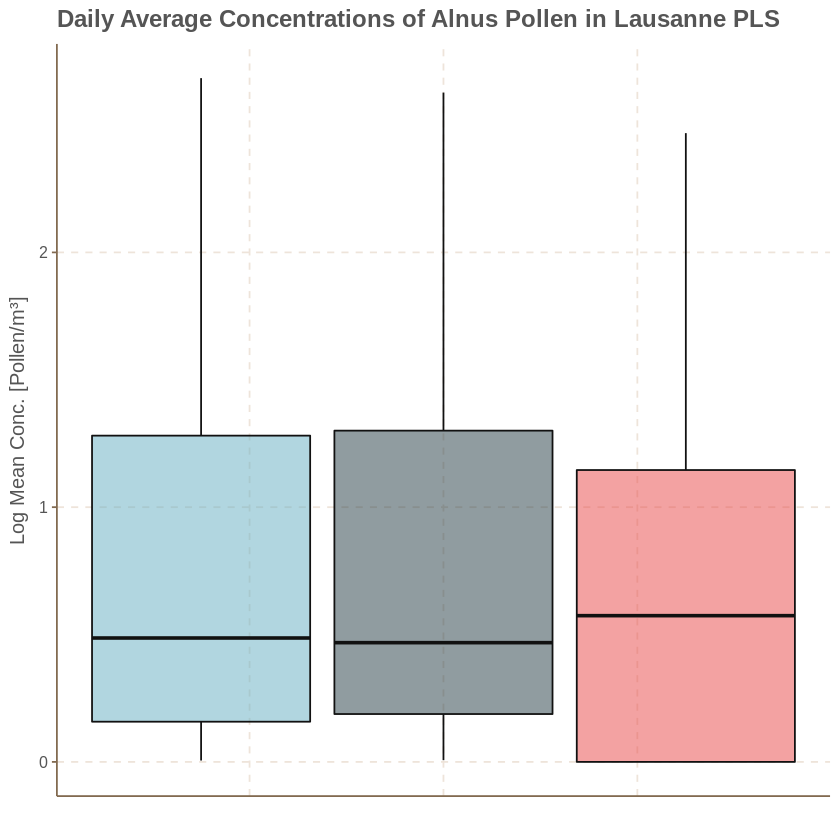

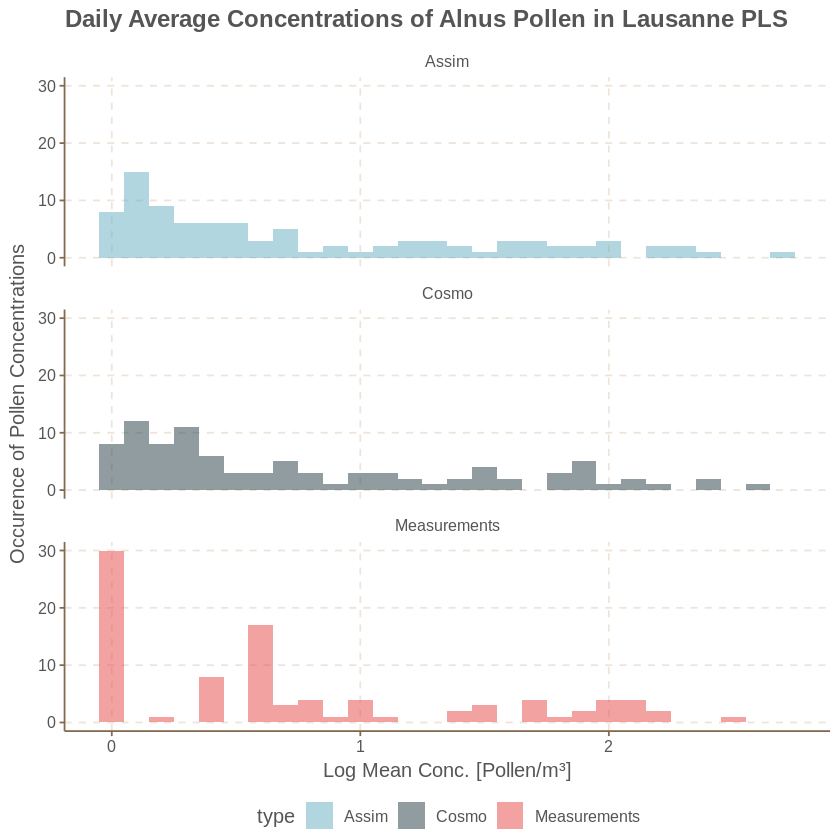

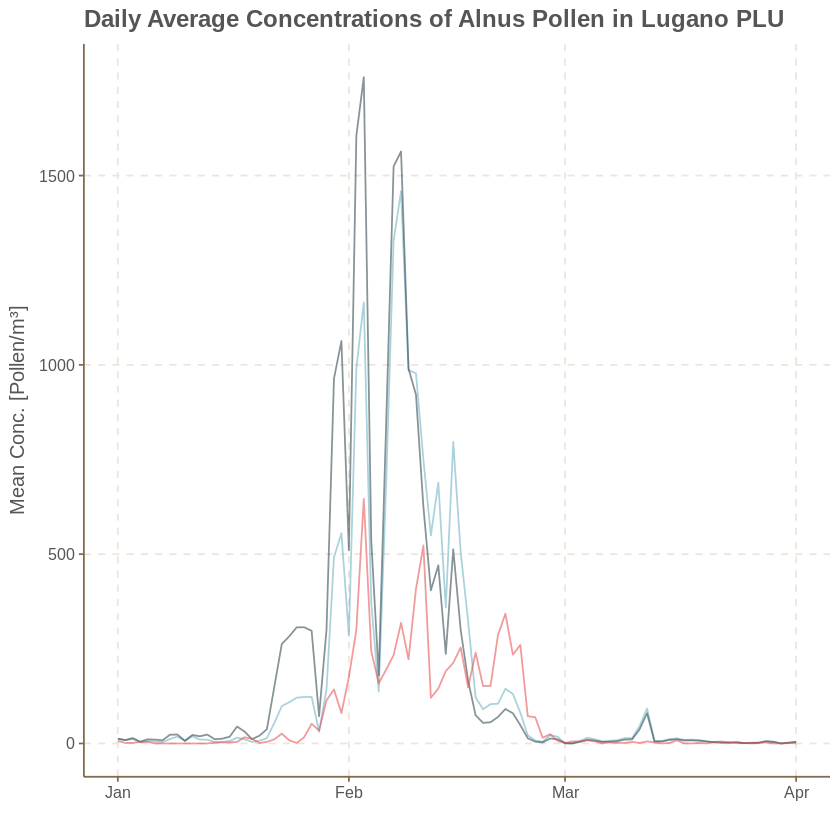

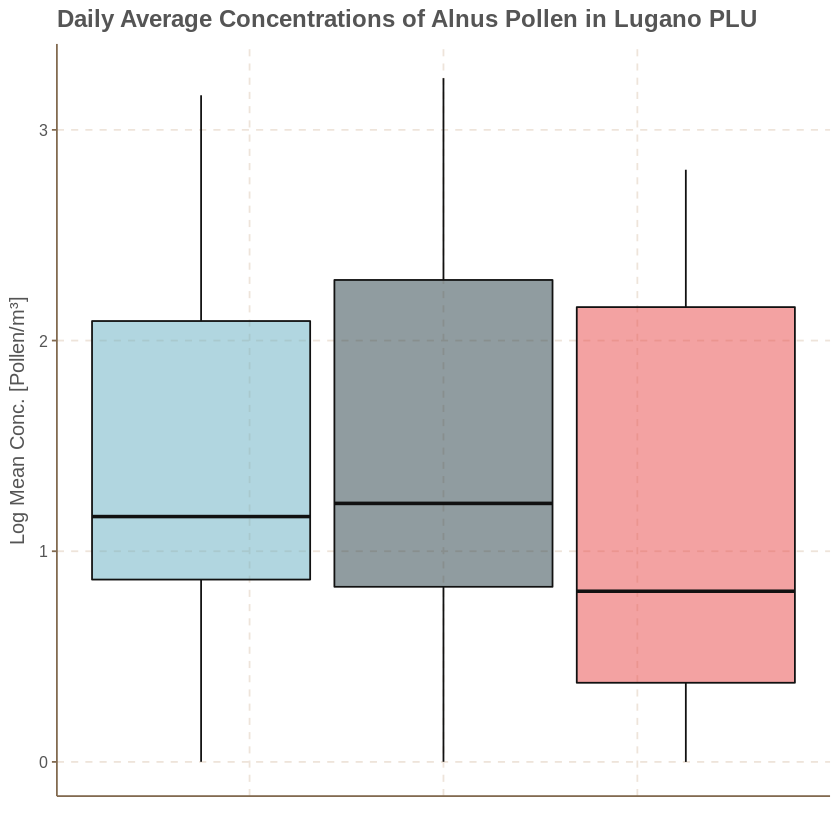

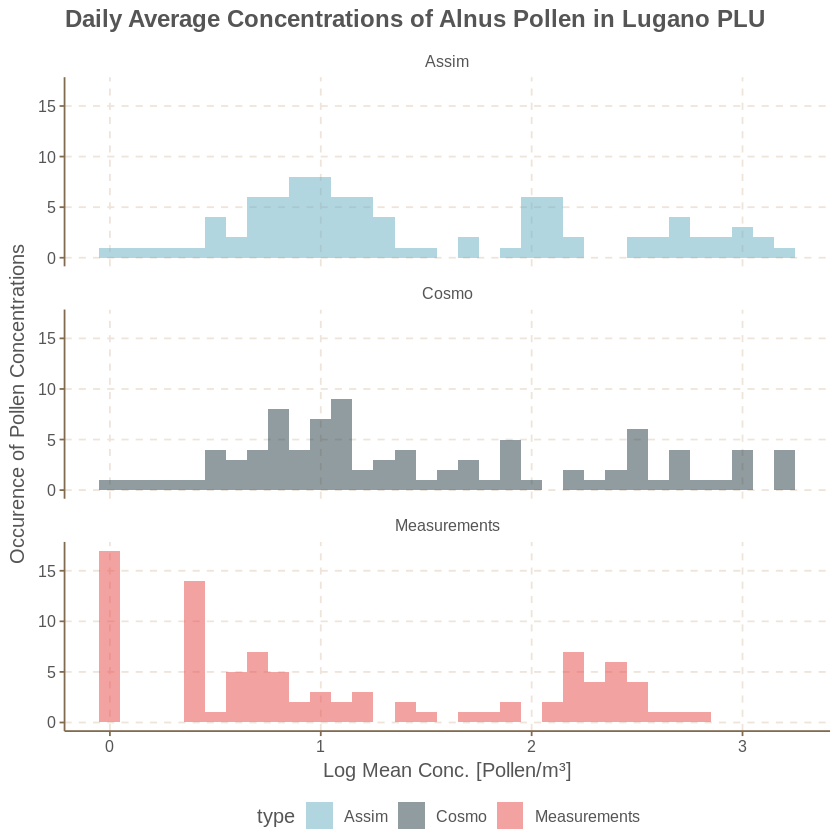

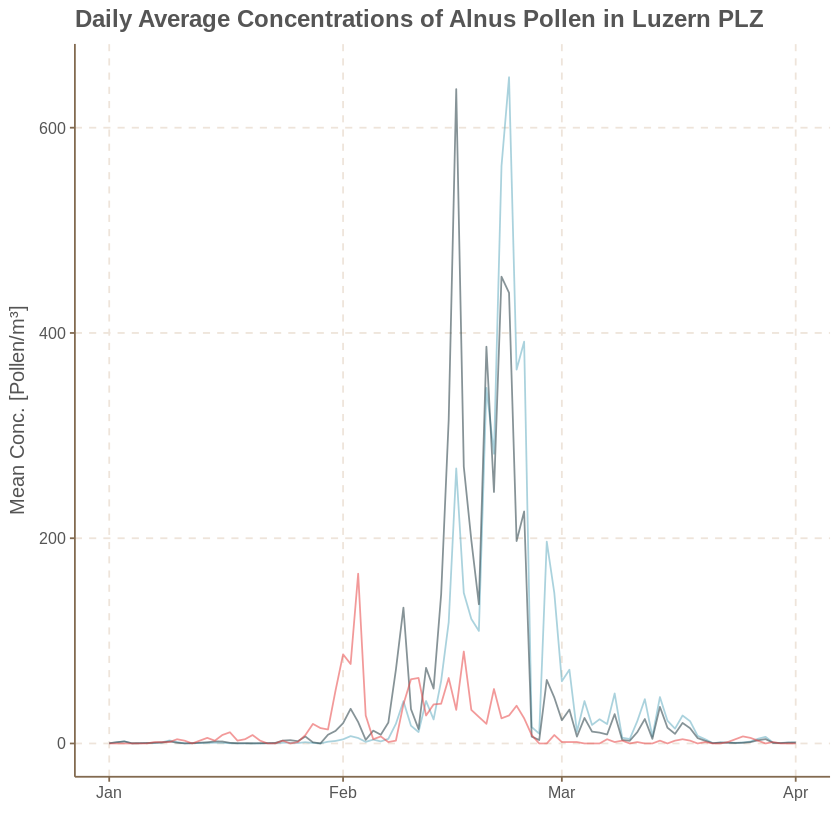

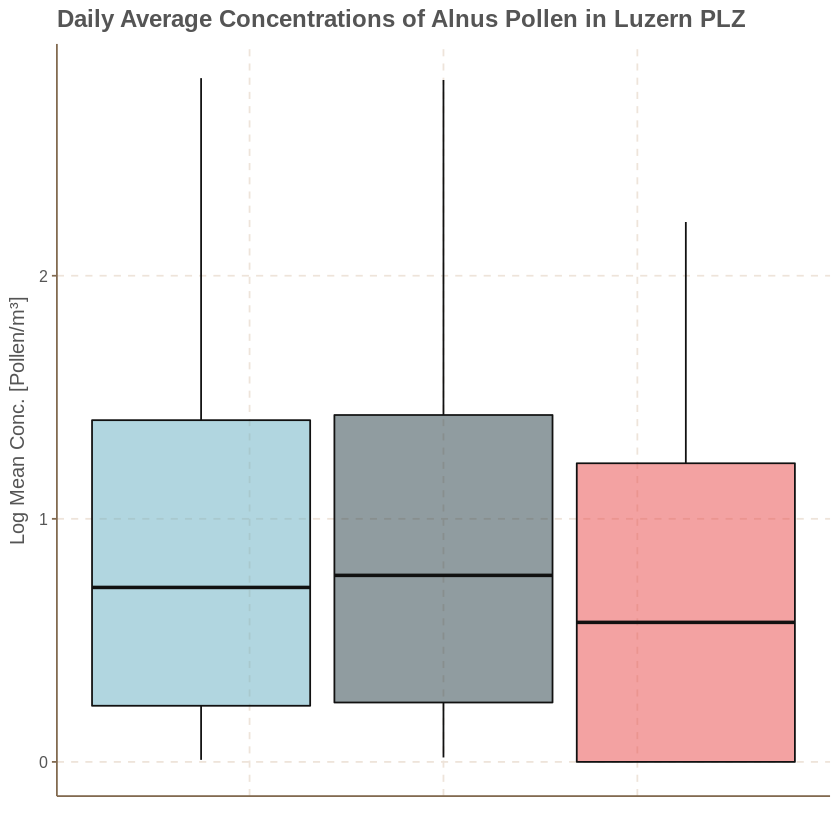

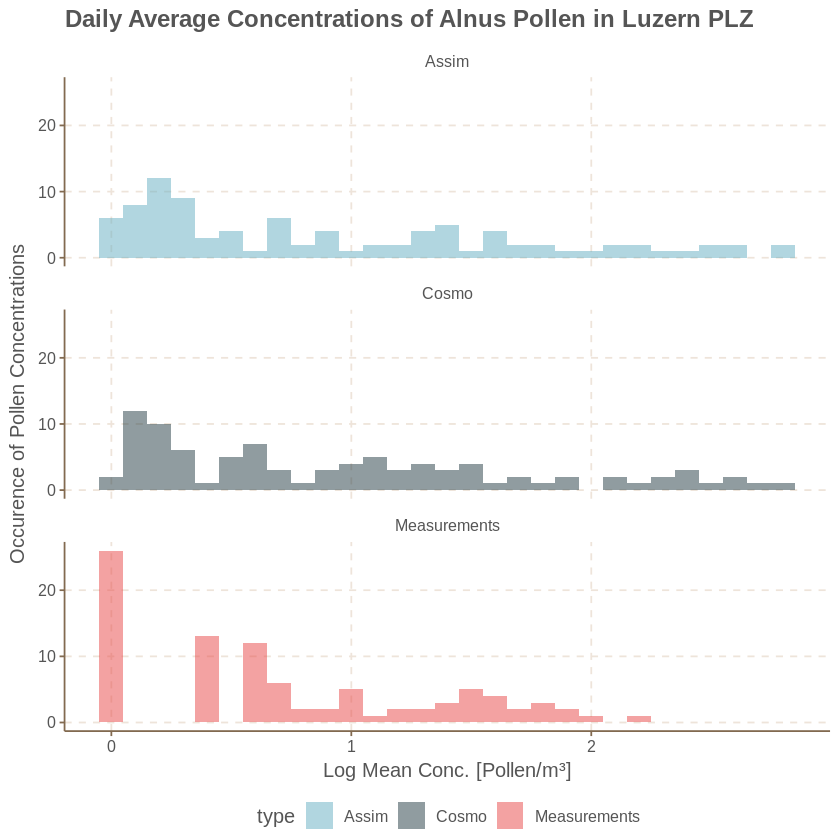

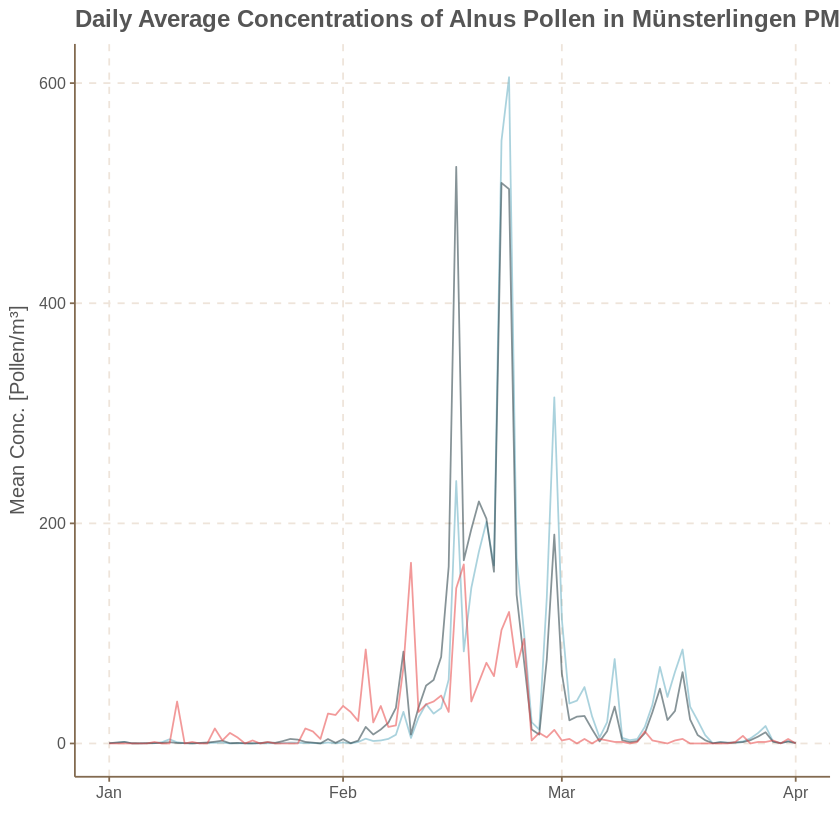

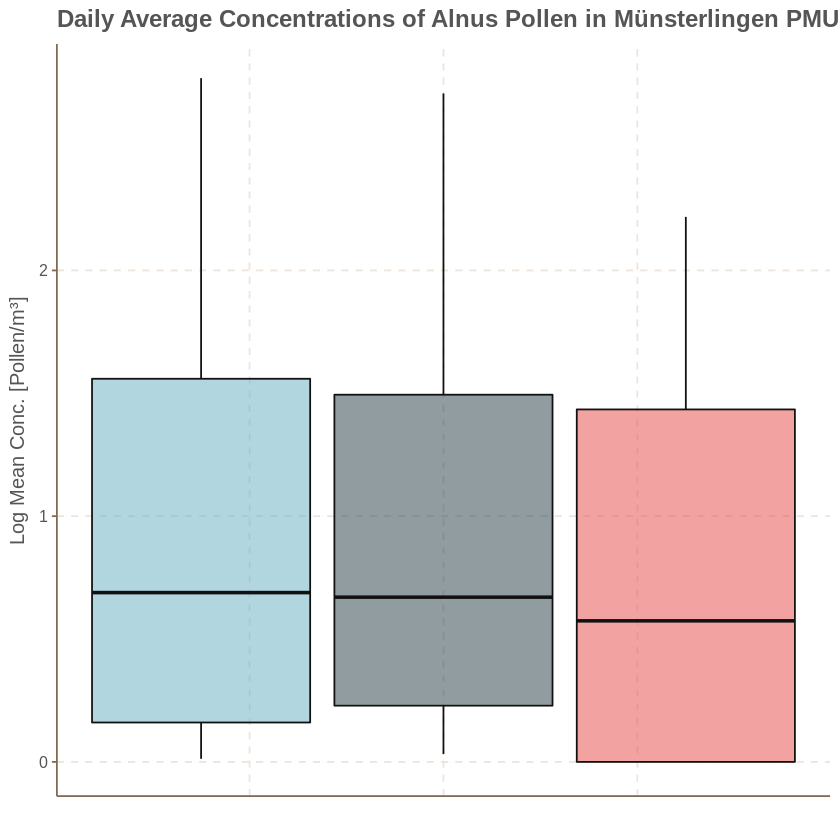

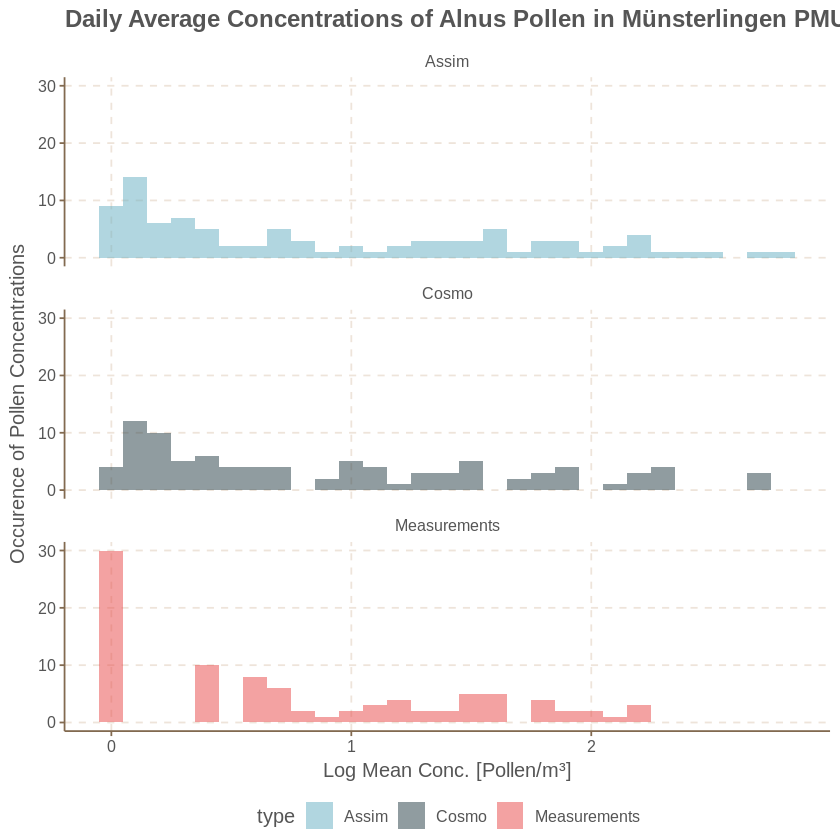

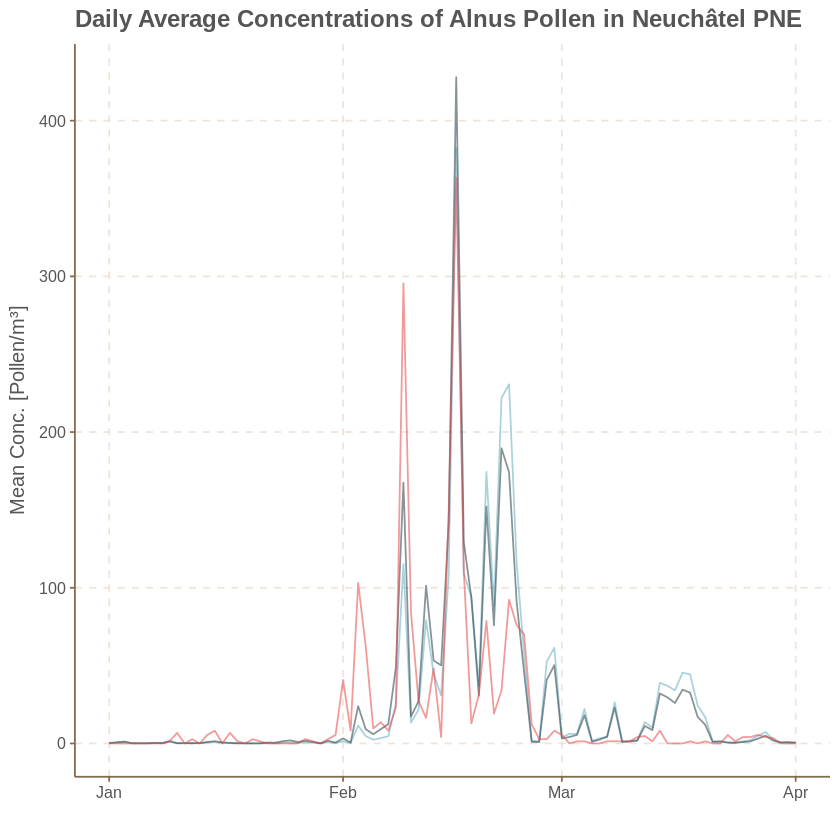

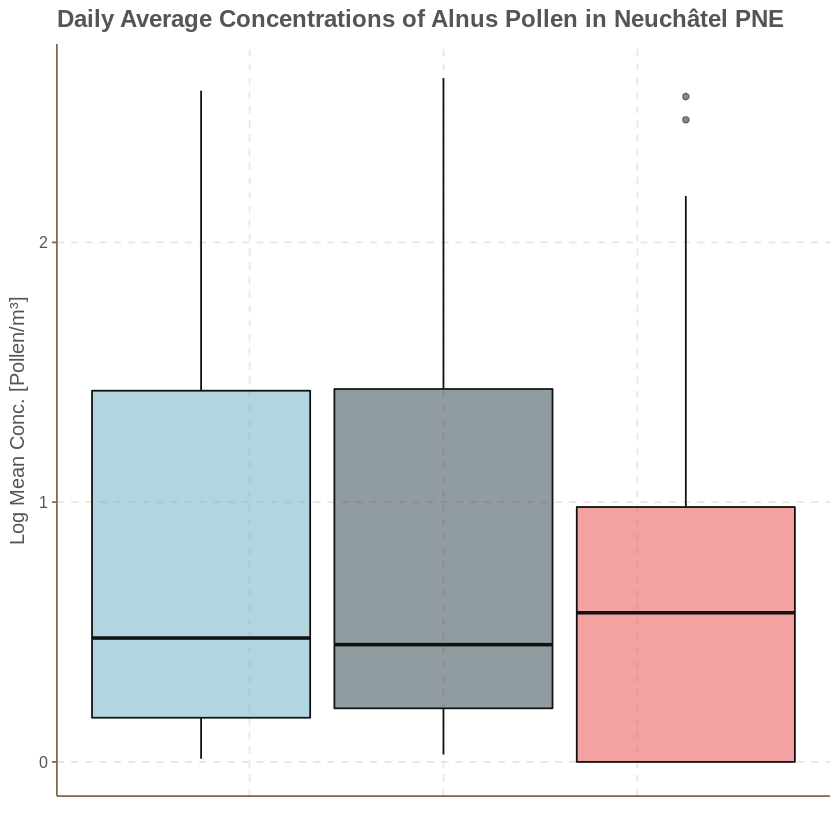

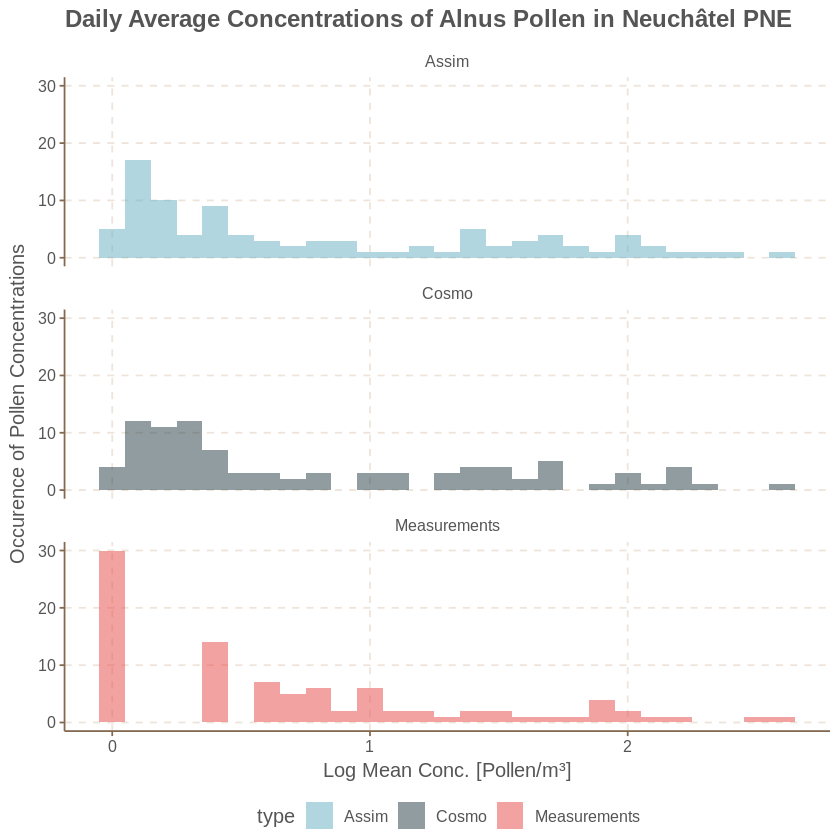

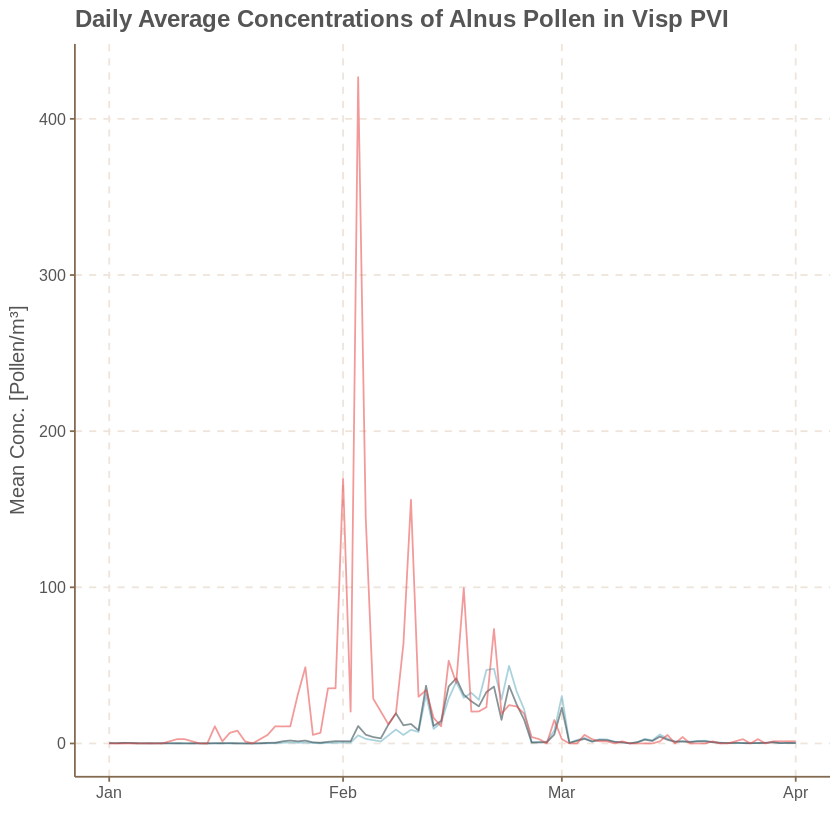

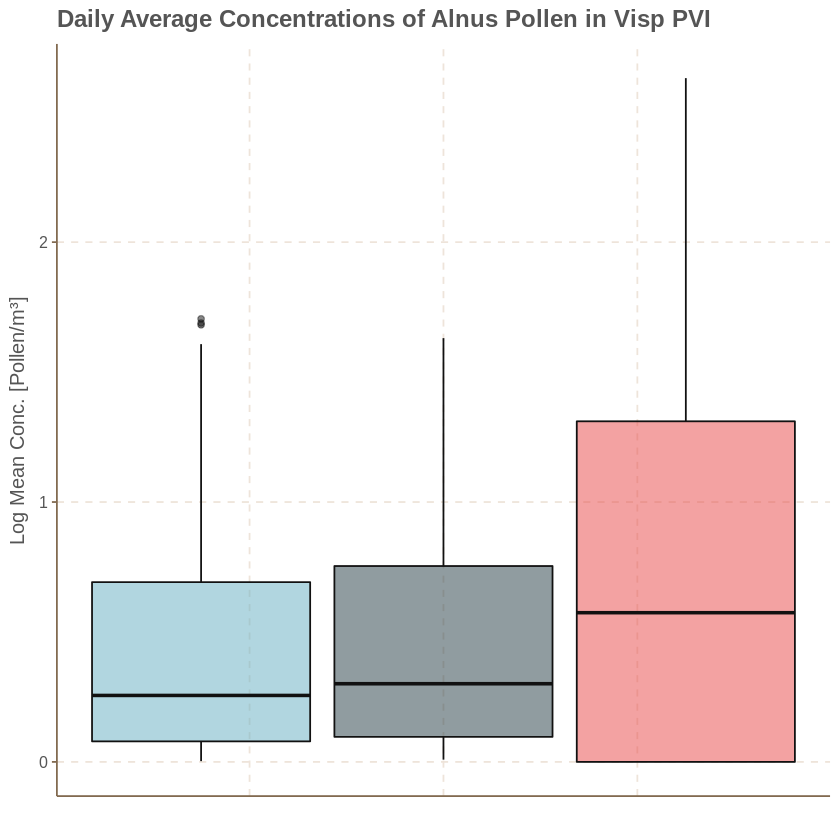

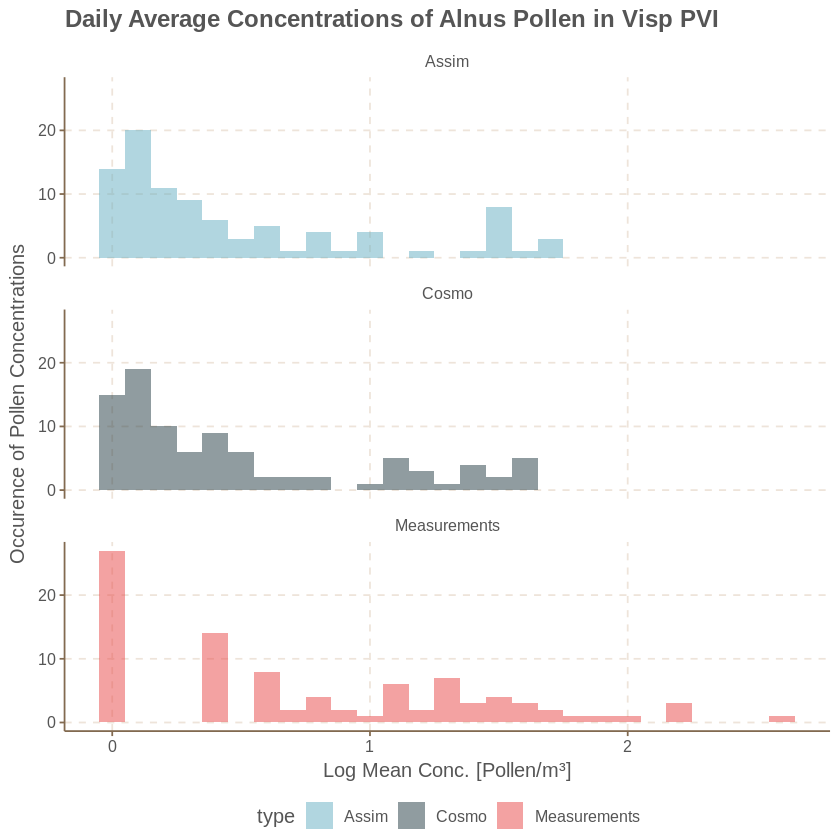

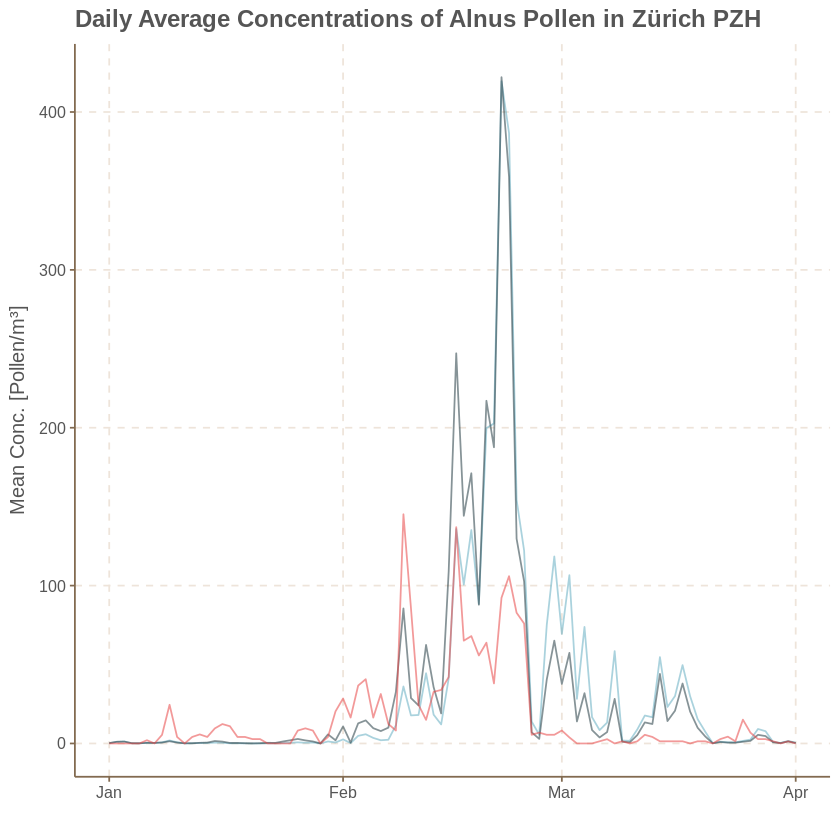

[[1]]
[[1]][[1]]

[[1]][[2]]

[[1]][[3]]


[[2]]
[[2]][[1]]

[[2]][[2]]

[[2]][[3]]


[[3]]
[[3]][[1]]

[[3]][[2]]

[[3]][[3]]


[[4]]
[[4]][[1]]

[[4]][[2]]

[[4]][[3]]


[[5]]
[[5]][[1]]

[[5]][[2]]

[[5]][[3]]


[[6]]
[[6]][[1]]

[[6]][[2]]

[[6]][[3]]


[[7]]
[[7]][[1]]

[[7]][[2]]

[[7]][[3]]


[[8]]
[[8]][[1]]

[[8]][[2]]

[[8]][[3]]


[[9]]
[[9]][[1]]

[[9]][[2]]

[[9]][[3]]


[[10]]
[[10]][[1]]

[[10]][[2]]

[[10]][[3]]


[[11]]
[[11]][[1]]

[[11]][[2]]

[[11]][[3]]


[[12]]
[[12]][[1]]

[[12]][[2]]

[[12]][[3]]


[[13]]
[[13]][[1]]

[[13]][[2]]

[[13]][[3]]


[[14]]
[[14]][[1]]

[[14]][[2]]

[[14]][[3]]



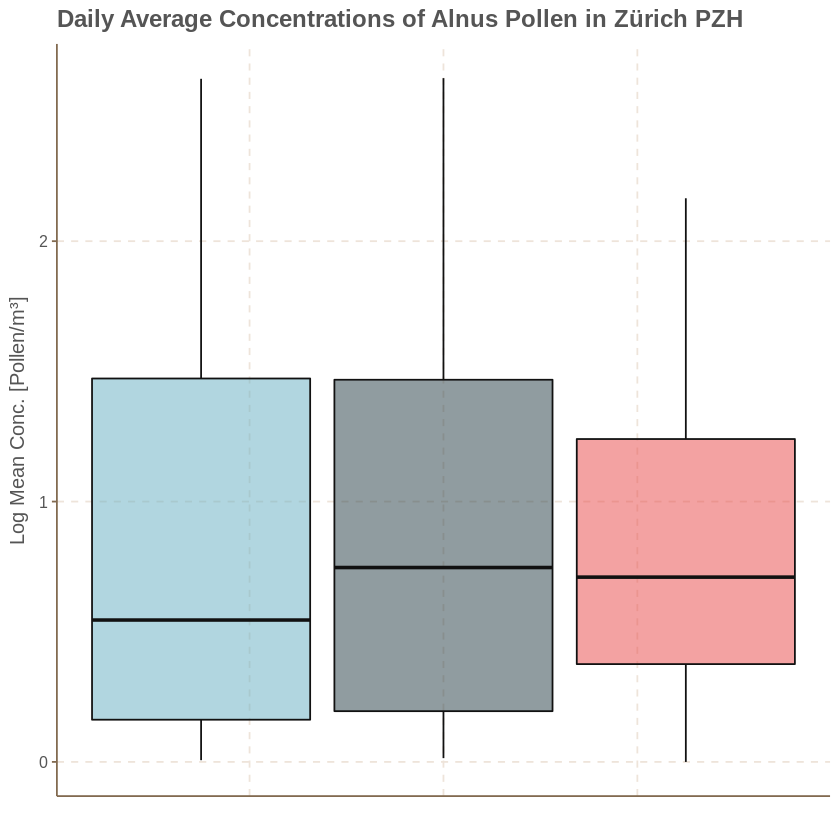

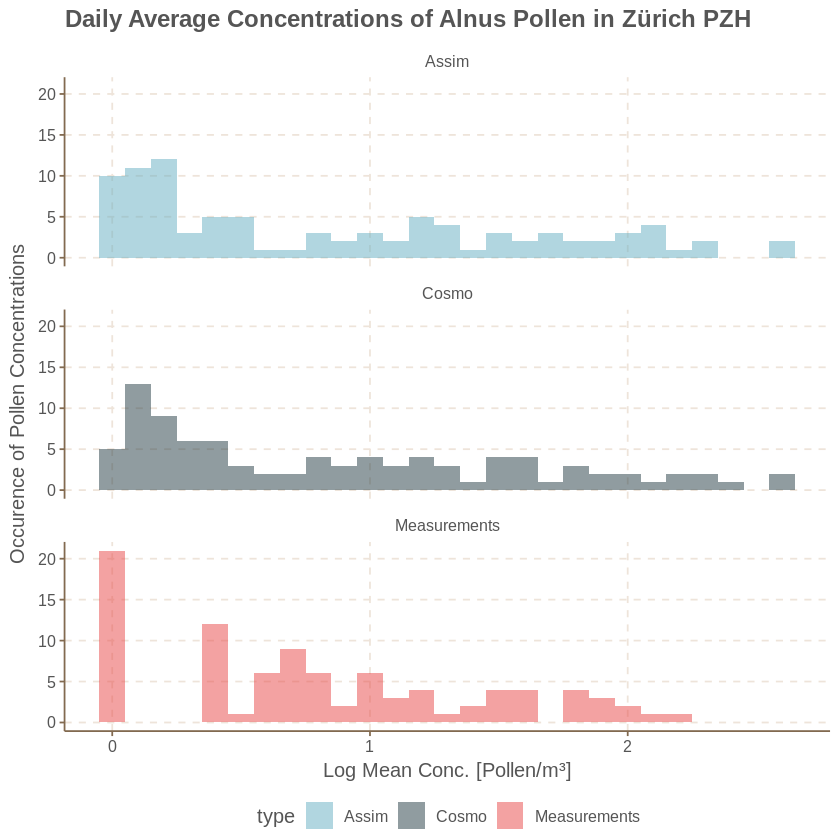

In [64]:
map(stations$station, ~ plot_comb(
  data_plot = data_comb_daily,
  taxon = taxa_selected,
  station = .x,
  resolution = "Daily",
  combined = FALSE,
  rm_zeros = FALSE,
  plot_dwh = TRUE
))


In [65]:

path_in <- paste0(here(), "/data/shapefiles/")
# read cantonal borders
canton_geo <- read_sf(paste0(path_in, "g2k15.shp"))
# read country borders - masking with read_sf didn't work
country_geo <- readOGR(paste0(path_in, "g2l15.shp"))
# read lakes
lake_geo <- read_sf(paste0(path_in, "g2s15.shp"))
# read productive area (2324 municipalities)
municipality_prod_geo <- read_sf(paste0(path_in, "gde-1-1-15.shp"))

# read in raster of relief
relief <- raster(paste0(path_in, "02-relief-ascii.asc")) %>%
  # hide relief outside of Switzerland by masking with country borders
  mask(country_geo) %>%
  as("SpatialPixelsDataFrame") %>%
  as.data.frame() %>%
  rename(value = `X02.relief.ascii`)

# clean up
rm(country_geo)

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum CH1903 in Proj4 definition: +proj=somerc +lat_0=46.9524055555556 +lon_0=7.43958333333333 +k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel +towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs”


OGR data source with driver: ESRI Shapefile 
Source: "/users/sadamov/RProjects/CHAPo/data/shapefiles/g2l15.shp", layer: "g2l15"
with 1 features
It has 12 fields


Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Bessel 1841 ellipsoid in Proj4 definition”


In [66]:
data <- data.table::fread(paste0(here(), "/data/model_output/mod_pollen.csv")) %>%
  slice(1) %>%
  pivot_longer(ch0001:ch6810, names_to = "bfs_id", values_to = "mean") %>%
  select(bfs_id, mean) %>%
  mutate(bfs_id = as.integer(str_replace_all(bfs_id, "ch", "")))

municipality_prod_geo %<>%
  left_join(data, by = c("BFS_ID" = "bfs_id"))

# define number of classes
no_classes <- 6

# extract quantiles
quantiles <- municipality_prod_geo %>%
  pull(mean) %>%
  quantile(probs = seq(0, 1, length.out = no_classes + 1)) %>%
  as.vector() # to remove names of quantiles, so idx below is numeric

# here we create custom labels
labels <- imap_chr(quantiles, function(., idx) {
  return(paste0(
    round(quantiles[idx], 0),
    " - ",
    round(quantiles[idx + 1], 0),
    " m^-3"
  ))
})

# we need to remove the last label
# because that would be something like "- NA"
labels <- labels[seq_len(length(labels)) - 1]

# here we actually create a new
# variable on the dataset with the quantiles
municipality_prod_geo %<>%
  mutate(mean_quantiles = cut(mean,
    breaks = quantiles,
    labels = labels,
    include.lowest = T
  ))



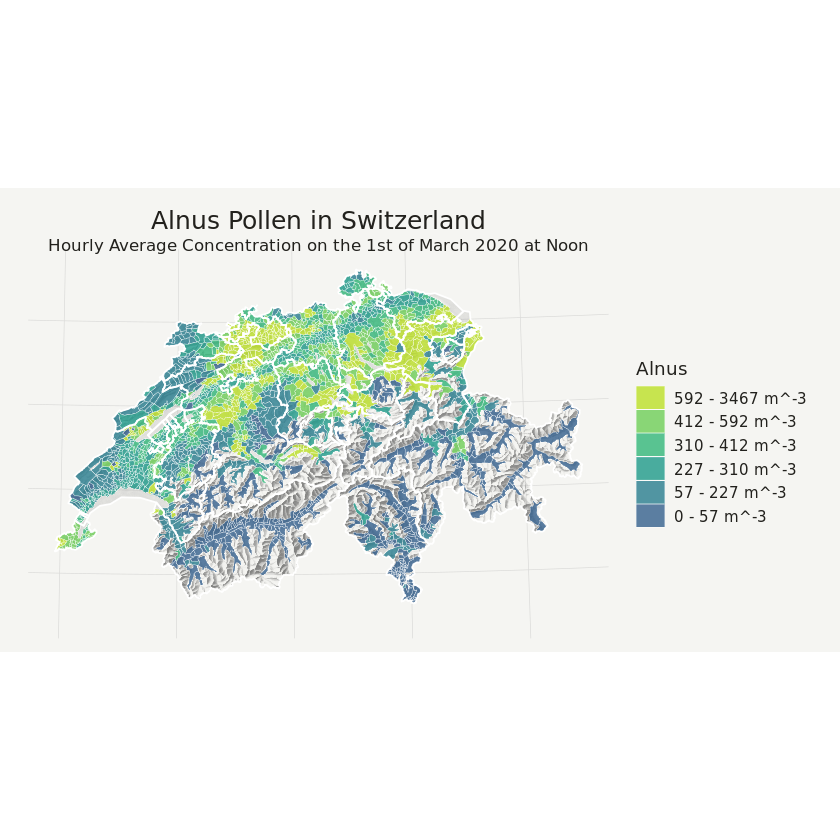

In [67]:

map_timo <- ggplot(
  # define main data source
  data = municipality_prod_geo
) +
  # first: draw the relief
  geom_raster(
    data = relief,
    inherit.aes = FALSE,
    aes(
      x = x,
      y = y,
      alpha = value
    )
  ) +
  # use the "alpha hack" (as the "fill" aesthetic is already taken)
  scale_alpha(
    name = "",
    range = c(0.6, 0),
    guide = F
  ) + # suppress legend
  # add main fill aesthetic
  # use thin white stroke for municipality borders
  geom_sf(
    mapping = aes(
      fill = mean_quantiles
    ),
    color = "white",
    size = 0.1
  ) +
  # use the Viridis color scale
  scale_fill_viridis(
    option = "viridis",
    name = "Alnus",
    alpha = 0.8, # make fill a bit brighter
    begin = 0.3, # this option seems to be new (compared to 2016):
    # with this we can truncate the
    # color scale, so that extreme colors (very dark and very bright) are not
    # used, which makes the map a bit more aesthetic
    end = 0.9,
    discrete = T, # discrete classes, thus guide_legend instead of _colorbar
    direction = 1, # dark is lowest, yellow is highest
    guide = guide_legend(
      keyheight = unit(5, units = "mm"),
      title.position = "top",
      reverse = T # display highest income on top
    )
  ) +
  # use thicker white stroke for cantonal borders
  geom_sf(
    data = canton_geo,
    fill = "transparent",
    color = "#ffffff",
    size = 0.5
  ) +
  # draw lakes in light blue
  geom_sf(
    data = lake_geo,
    fill = "#acc42500",
    color = "transparent"
  ) +
  # add titles
  labs(
    x = NULL,
    y = NULL,
    title = "Alnus Pollen in Switzerland",
    subtitle = paste("Hourly Average Concentration on",
       "the 1st of March 2020 at Noon")
  ) +
  # add theme
  my_maptheme()
map_timo
# ggsave(paste0(here(), "/map_timo.png"), map_timo, dpi = "retina")

In [68]:

data_comb_daily %>%
  group_by(taxon, station, type) %>%
  summarise(value = sum(value != 0)) %>%
  ungroup() %>%
  mutate(metric = "occurence")

data_comb_daily %>%
  group_by(taxon, station, type) %>%
  summarise(value = max(value)) %>%
  ungroup() %>%
  mutate(metric = "maximum")

data_comb_daily %>% # This would need a season definition
  group_by(taxon, station, type) %>%
  summarise(value = mean(value)) %>%
  ungroup() %>%
  mutate(metric = "average")

data_comb_daily %>%
  group_by(taxon, station, type) %>%
  summarise(value = sum(value)) %>%
  ungroup() %>%
  mutate(metric = "spi")



`summarise()` has grouped output by 'taxon', 'station'. You can override using the `.groups` argument.



taxon,station,type,value,metric
<chr>,<chr>,<chr>,<int>,<chr>
Alnus,Basel,Assim,92,occurence
Alnus,Basel,Cosmo,92,occurence
Alnus,Basel,Measurements,59,occurence
Alnus,Bern,Assim,92,occurence
Alnus,Bern,Cosmo,92,occurence
Alnus,Bern,Measurements,64,occurence
Alnus,Buchs,Assim,92,occurence
Alnus,Buchs,Cosmo,92,occurence
Alnus,Buchs,Measurements,79,occurence


`summarise()` has grouped output by 'taxon', 'station'. You can override using the `.groups` argument.



taxon,station,type,value,metric
<chr>,<chr>,<chr>,<dbl>,<chr>
Alnus,Basel,Assim,802.72375,maximum
Alnus,Basel,Cosmo,903.48354,maximum
Alnus,Basel,Measurements,254.87500,maximum
Alnus,Bern,Assim,394.02062,maximum
Alnus,Bern,Cosmo,430.22917,maximum
Alnus,Bern,Measurements,189.04167,maximum
Alnus,Buchs,Assim,584.63042,maximum
Alnus,Buchs,Cosmo,384.15167,maximum
Alnus,Buchs,Measurements,199.37500,maximum


`summarise()` has grouped output by 'taxon', 'station'. You can override using the `.groups` argument.



taxon,station,type,value,metric
<chr>,<chr>,<chr>,<dbl>,<chr>
Alnus,Basel,Assim,72.425717,average
Alnus,Basel,Cosmo,71.827467,average
Alnus,Basel,Measurements,23.681543,average
Alnus,Bern,Assim,35.249766,average
Alnus,Bern,Cosmo,36.982183,average
Alnus,Bern,Measurements,19.262640,average
Alnus,Buchs,Assim,35.648398,average
Alnus,Buchs,Cosmo,32.227275,average
Alnus,Buchs,Measurements,18.867596,average


`summarise()` has grouped output by 'taxon', 'station'. You can override using the `.groups` argument.



taxon,station,type,value,metric
<chr>,<chr>,<chr>,<dbl>,<chr>
Alnus,Basel,Assim,6663.1659,spi
Alnus,Basel,Cosmo,6608.1269,spi
Alnus,Basel,Measurements,2178.7020,spi
Alnus,Bern,Assim,3242.9785,spi
Alnus,Bern,Cosmo,3402.3609,spi
Alnus,Bern,Measurements,1772.1629,spi
Alnus,Buchs,Assim,3279.6527,spi
Alnus,Buchs,Cosmo,2964.9093,spi
Alnus,Buchs,Measurements,1735.8188,spi


In [69]:
data_verif <- data_comb_daily %>%
  filter(type != "Cosmo")

In [ ]:
# Check stations tibble for all available locations
stations_selected <- "Basel"
gg_timeseries <- list()

for (s in stations_selected %>% sort()) {
  data_timeseries <- data_verif %>%
    filter(
      taxon %in% taxa_selected,
      station %in% s
    )

  large_diffs <- data_timeseries %>%
    pivot_wider(names_from = type) %>%
    mutate(
      diff = Hirst - Assim,
      mean_pol = (Hirst + Assim) / 2,
      large_diff = if_else(Hirst > 20 & ((abs(diff) + mean_pol) / mean_pol > 2),
        date,
        as.Date(NA)
      )
    ) %>%
    pull(large_diff) %>%
    unique()

  gg_timeseries[[s]] <- data_timeseries %>%
    ggplot(aes(x = datetime, y = value, col = type, lty = type)) +
    geom_line(alpha = 0.6) +
    geom_vline(
      xintercept = large_diffs,
      alpha = 0.1,
      col = swatch()[1], size = 1
    ) +
    ggtitle(paste(
      "Hourly", paste(taxa_selected, collapse = ", "),
      "Pollen Concentrations in",
      s
    )) +
    labs(
      y = expression(paste("Pollen Concentration [", m^-3, "]")),
      x = "2020 Season"
    ) +
    scale_colour_manual("Data", values = swatch()[c(2, 4)]) +
    guides(lty = FALSE)
}

gg_timeseries

In [ ]:

methods <- c("pearson", "spearman", "kendall")

data_corr <- data_verif %>%
  filter(measurement == "concentration") %>%
  # For the robust methods transformation doesn't matter
  mutate(value = log10(value + 1)) %>%
  select(value, type, datetime, station, taxon) %>%
  pivot_wider(names_from = type, values_from = value)

data_corr_exp <- data_verif %>%
  filter(measurement == "concentration") %>%
  select(value, type, datetime, station, taxon) %>%
  pivot_wider(names_from = type, values_from = value)

corr_matrix <- map(methods, ~ corr.test(
  data_corr %>% select(-datetime, -station, -taxon),
  # use = "complete", # There should be only complete observations
  method = .x,
  # adjust = "holm",
  alpha = .05,
  ci = TRUE,
  minlength = 5
))

In [ ]:

max_val <- max(data_corr_exp$Assim, na.rm = TRUE)

ggthemr("fresh")
ci <- map(corr_matrix, ~ .x %>%
  pluck(10)) %>%
  bind_rows() %>%
  round(2) %>%
  mutate(
    method = methods,
    metric = c("R-", "rho-", "tau-"),
    ci = tools::toTitleCase(paste0(
      metric,
      method,
      ": ",
      lower.adj,
      " - ",
      upper.adj
    )),
    x = rep(max_val * 0.1, times = 3),
    y = c(max_val, max_val * 0.95, max_val * 0.9)
  )

gg_corr <- data_corr_exp %>%
  ggplot(aes(x = Hirst, y = Assim)) +
  geom_point(alpha = 0.3) +
  # The smoother is dependent on the scale
  geom_smooth(alpha = 0.1) +
  geom_abline(slope = 1, intercept = 0, col = swatch()[4]) +
  geom_label(data = ci, aes(label = ci, x = x, y = y), parse = TRUE) +
  scale_x_continuous(
    name = "Measured Pollen Concentration [m⁻³]",
    limits = c(0, max_val)
  ) +
  scale_y_continuous(
    name = "Modelled Pollen Concentration [m⁻³]",
    limits = c(0, max_val)
  )

title <- tools::toTitleCase(paste0(
  "Comparison of Daily average",
  " concentrations of measured and modelled pollen concentrations"
))

gg_corr <- ggarrange(gg_corr) %>%
  annotate_figure(
    top = title,
    bottom = text_grob(paste0("Pairwise correlation between measured and ",
      "modelled data; grey line shows the Loess smother; the red line shows",
      "a theroratical perfect correlation of 1. \n In the text box one can",
      "see the 95% confidence intervals of the R-values (adjusted for multiple",
      "comparison) as obtained by Pearson and two robust methods."),
      color = swatch()[1],
      face = "italic",
      size = 10
    )
)


gg_corr


In [ ]:
ggsave(
  filename = paste0(here::here(), "/vignettes/figures/corr_plot.png"),
  gg_corr,
  width = 12,
  height = 8
)

In [ ]:
data_altman <- data_corr %>%
  mutate(
    mean = if_else(!is.na(Hirst) | !is.na(Assim),
      rowSums(.[4:5], na.rm = TRUE) / 2,
      NA_real_
    ),
    diff = Hirst - Assim
  )

data_altman_exp <- data_corr_exp %>%
  mutate(
    mean = if_else(!is.na(Hirst) | !is.na(Assim),
      rowSums(.[4:5], na.rm = TRUE) / 2,
      NA_real_
    ),
    diff = Hirst - Assim
  )

In [ ]:

categs <- c("weak", "medium", "strong", "verystrong")

data_conc <- data_altman_exp %>%
  filter(mean >= 1) %>%
  mutate(conc = case_when(
    taxon == "Alnus" & mean >= 1 & mean <= 10 ~ "weak",
    taxon == "Alnus" & mean >= 11 & mean <= 69 ~ "medium",
    taxon == "Alnus" & mean >= 70 & mean <= 249 ~ "strong",
    taxon == "Alnus" & mean >= 250 ~ "verystrong",
    taxon == "Betula" & mean >= 1 & mean <= 10 ~ "weak",
    taxon == "Betula" & mean >= 11 & mean <= 69 ~ "medium",
    taxon == "Betula" & mean >= 70 & mean <= 299 ~ "strong",
    taxon == "Betula" & mean >= 300 ~ "verystrong",
    taxon == "Poaceae" & mean >= 1 & mean <= 19 ~ "weak",
    taxon == "Poaceae" & mean >= 20 & mean <= 49 ~ "medium",
    taxon == "Poaceae" & mean >= 50 & mean <= 149 ~ "strong",
    taxon == "Poaceae" & mean >= 150 ~ "verystrong",
    taxon == "Ambrosia" & mean >= 1 & mean <= 5 ~ "weak",
    taxon == "Ambrosia" & mean >= 6 & mean <= 10 ~ "medium",
    taxon == "Ambrosia" & mean >= 11 & mean <= 39 ~ "strong",
    taxon == "Ambrosia" & mean >= 40 ~ "verystrong"
  )) %>%
  pivot_longer(Hirst:Assim, names_to = "type", values_to = "value") %>%
  pivot_wider(names_from = conc, values_from = value)

gg_conc_dens <- list()

labels_y <- list(0.1, 0.015, 0.004, 0.002)
# For 2-hours labels_y <- list(0.75, 0.03, 0.015, 0.010, 0.005, 0.0012)
labels_y_hist <- list(15, 13, 10, 10, 7.5, 3)
names(labels_y) <- categs

for (j in categs) {
  if (j %in% names(data_conc)) {
    obs <- data_conc %>%
      filter(!is.na(!!sym(j))) %>%
      summarise(n() / 2) %>%
      pull()
    obs <- paste("# of Observations:", obs)

    gg_conc_dens[[j]] <- data_conc %>%
      filter(!is.na(!!sym(j))) %>%
      ggplot() +
      # The area under that whole curve should be 1.
      # To get an estimate of the probability of certain values,
      # you'd have to integrate over an interval on your 'y' axis,
      # and that value should never be greater than 1.
      geom_density(aes(x = !!sym(j), col = type, fill = type), alpha = 0.15) +
      geom_label(label = obs, aes(x = max(!!sym(j)) * 0.7), y = labels_y[[j]]) +
      scale_colour_manual("", values = swatch()[c(2, 4)]) +
      scale_fill_manual(values = swatch()[c(2, 4)]) +
      coord_cartesian(xlim = c(0, NA)) +
      guides(fill = FALSE)
  }
}

gg_dens_conc <- ggarrange(plotlist = gg_conc_dens) %>%
  annotate_figure(
    top = paste(
      "Comparison of Measurements of the Three",
      "Traps for all Species and Different Concentration Groups."
    ),
    bottom = text_grob(paste0("We are looking at Density Kernel Estimators",
      "for all three traps to compare the measurements between them.",
      "\n The area under each curve adds up to 1 and makes it possible",
      "to vizualise the (dis-)similarities of measurements from the",
      " three traps. \n It is basically a smoothed histogram.",
      " The buckets are definedbased on the mean."),
      color = swatch()[1],
      face = "italic",
      size = 10
    )
  )

gg_dens_conc


In [ ]:
ggsave(
  filename = paste0(here::here(), "/vignettes/figures/density_plot.png"),
  gg_dens_conc,
  width = 12,
  height = 8
)

In [ ]:

data_conc_plot <- data_conc %>%
  pivot_longer(categs[categs %in% names(data_conc)],
    names_to = "group",
    values_to = "value"
  ) %>%
  mutate(
    group = factor(group, levels = categs[categs %in% names(data_conc)]),
    reldiff = diff / mean - 1
  ) %>%
  filter(!is.na(value))

means <- data_conc_plot %>%
  group_by(group, type) %>%
  summarise(mean = mean(reldiff))

gg_boxplot_reldiff <- data_conc_plot %>%
  ggplot(aes(x = group, y = reldiff)) +
  geom_boxplot(alpha = 0.6) +
  geom_point(
    data = means, aes(x = group, y = mean),
    position = position_dodge(width = 0.75),
    shape = 95,
    size = 10,
    show.legend = FALSE
  ) +
  labs(
    x = "",
    y = "(Hirst - Cosmo) / mean(Hirst, Cosmo)",
    title = paste("Relative Pairwise Differences for",
    "Daily Average Pollen-Concentrations")
  ) +
  facet_wrap(~taxon)

gg_boxplot_reldiff


In [ ]:
ggsave(
  filename = paste0(here::here(), "/vignettes/figures/diff_boxplot.png"),
  gg_boxplot_reldiff,
  width = 12,
  height = 8
)

In [ ]:
diff_selection <- taxa_selected

kable_diff <- map(
  diff_selection,
  ~ data_conc_plot %>%
    filter(taxon %in% .x) %>%
    group_by(group, type) %>%
    summarise(
      q25 = quantile(reldiff, probs = 0.25, na.rm = TRUE),
      median = median(reldiff, na.rm = TRUE),
      q75 = quantile(reldiff, probs = 0.75, na.rm = TRUE)
    ) %>%
    ungroup() %>%
    group_by(group) %>%
    summarise_at(vars(q25, median, q75), ~ mean(.)) %>%
    ungroup()
) %>%
  bind_rows()

taxon <- data_conc_plot %>%
  group_by(group) %>%
  summarise(taxon = unique(taxon)) %>%
  select(taxon) %>%
  arrange(taxon) %>%
  ungroup

kable_diff %>%
  bind_cols(taxon) %>%
  mutate_at(
    vars(q25, median, q75),
    ~ scales::percent(signif(., 3),
      accuracy = 0.01
    )
  ) %>%
  select(taxon, everything()) %>%
  setNames(c("Species", "Class", "25%-Quantile", "Median", "75%-Quantile")) %>%
  kable(escape = FALSE, align = c("c", "c", "r", "r", "r")) %>%
  kable_styling("striped", full_width = FALSE) %>%
  collapse_rows(columns = 1)


In [ ]:

sd_diff <- data_altman %>%
  summarise(sd_diff = sd(diff, na.rm = TRUE)) %>%
  pull(sd_diff)

gg_ab1 <- data_altman %>%
  filter(!is.na(diff)) %>%
  ggplot(aes(x = mean, y = diff)) +
  geom_point(alpha = 0.5) +
  coord_cartesian(
    xlim = c(
      min(data_altman$mean),
      max(data_altman$mean)
    ),
    ylim = c(
      -sd_diff[1] * 4,
      sd_diff[1] * 4
    )
  ) +
  geom_abline(slope = 0, intercept = 0, col = swatch()[4], alpha = 0.8) +
  geom_abline(
    slope = 0,
    intercept = sd_diff[1] * 2,
    col = swatch()[4],
    alpha = 0.8,
    linetype = 3
  ) +
  geom_abline(
    slope = 0,
    intercept = sd_diff[1] * (-2),
    col = swatch()[4],
    alpha = 0.8,
    linetype = 3
  ) +
  geom_smooth(alpha = 0.1) +
  labs(y = "Difference(Hirst - Cosmo)", x = "Mean(Hirst, Cosmo)") +
  facet_wrap(~taxon)

title <- paste0(
  "Altman-Bland Plot to Compare",
  "Measured and Modelled Pollen Concentrations"
)

gg_altman <- ggarrange(gg_ab1) %>%
  annotate_figure(top = title, bottom = text_grob(paste0(
    "Pairwise comparison of traps; grey line shows the Loess smother;",
    " the red line shows a theroratical perfect agreement between two ",
    "traps of zero. \n The dashed red line shows the 2 * sd of the ",
    "differences, where we expect the points to lie within."
  ),
  color = swatch()[1],
  face = "italic",
  size = 12
  ))

gg_altman

In [ ]:
ggsave(
  filename = paste0(
    here::here(),
    "/vignettes/figures/altman-bland.png"
  ),
  gg_altman,
  width = 12,
  height = 8
)

In [ ]:
data_conc_plot %>%
  pivot_wider(names_from = type, values_from = value) %>%
  summarise(
    R2 = cor(Hirst, Assim, use = "complete.obs")^2,
    MSE = mean((Hirst - Assim)^2, na.rm = TRUE),
    RMSE = sqrt(MSE),
    MAE = mean(abs(Hirst - Assim), na.rm = TRUE)
  )

In [ ]:
data_valid <- data_altman_exp %>%
  mutate(
    conc_hirst = case_when(
      taxon == "Alnus" & Hirst >= 1 & Hirst <= 10 ~ "weak",
      taxon == "Alnus" & Hirst >= 11 & Hirst <= 69 ~ "medium",
      taxon == "Alnus" & Hirst >= 70 & Hirst <= 249 ~ "strong",
      taxon == "Alnus" & Hirst >= 250 ~ "verystrong",
      taxon == "Betula" & Hirst >= 1 & Hirst <= 10 ~ "weak",
      taxon == "Betula" & Hirst >= 11 & Hirst <= 69 ~ "medium",
      taxon == "Betula" & Hirst >= 70 & Hirst <= 299 ~ "strong",
      taxon == "Betula" & Hirst >= 300 ~ "verystrong",
      taxon == "Poaceae" & Hirst >= 1 & Hirst <= 19 ~ "weak",
      taxon == "Poaceae" & Hirst >= 20 & Hirst <= 49 ~ "medium",
      taxon == "Poaceae" & Hirst >= 50 & Hirst <= 149 ~ "strong",
      taxon == "Poaceae" & Hirst >= 150 ~ "verystrong",
      taxon == "Ambrosia" & Hirst >= 1 & Hirst <= 5 ~ "weak",
      taxon == "Ambrosia" & Hirst >= 6 & Hirst <= 10 ~ "medium",
      taxon == "Ambrosia" & Hirst >= 11 & Hirst <= 39 ~ "strong",
      taxon == "Ambrosia" & Hirst >= 40 ~ "verystrong"
    ),
    conc_assim = case_when(
      taxon == "Alnus" & Assim >= 1 & Assim <= 10 ~ "weak",
      taxon == "Alnus" & Assim >= 11 & Assim <= 69 ~ "medium",
      taxon == "Alnus" & Assim >= 70 & Assim <= 249 ~ "strong",
      taxon == "Alnus" & Assim >= 250 ~ "verystrong",
      taxon == "Betula" & Assim >= 1 & Assim <= 10 ~ "weak",
      taxon == "Betula" & Assim >= 11 & Assim <= 69 ~ "medium",
      taxon == "Betula" & Assim >= 70 & Assim <= 299 ~ "strong",
      taxon == "Betula" & Assim >= 300 ~ "verystrong",
      taxon == "Poaceae" & Assim >= 1 & Assim <= 19 ~ "weak",
      taxon == "Poaceae" & Assim >= 20 & Assim <= 49 ~ "medium",
      taxon == "Poaceae" & Assim >= 50 & Assim <= 149 ~ "strong",
      taxon == "Poaceae" & Assim >= 150 ~ "verystrong",
      taxon == "Ambrosia" & Assim >= 1 & Assim <= 5 ~ "weak",
      taxon == "Ambrosia" & Assim >= 6 & Assim <= 10 ~ "medium",
      taxon == "Ambrosia" & Assim >= 11 & Assim <= 39 ~ "strong",
      taxon == "Ambrosia" & Assim >= 40 ~ "verystrong"
    )
  ) %>%
  filter(
    !is.na(conc_hirst),
    !is.na(conc_assim)
  ) %>%
  mutate_at(
    vars(conc_hirst, conc_assim),
    ~ factor(., levels = c("weak", "medium", "strong", "verystrong"))
  )

confusionMatrix(data_valid$conc_assim, data_valid$conc_hirst)